#### <h1 align=center><font size = 5>Capstone Project -18 : Crop Recommendation System</font></h1>
<h2 align=center><font size = 5>AIML Certification Programme</font></h2>

## Team
1. ANUJ ALEX
2. KALWAN GURBACHANSINGH
3. SIDDHARTH GUPTA
4. KRISHNA MURTHY P
5. SREE RAMA KUMAR YEDDANAPUDI

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import re
from rapidfuzz import process, fuzz
from sklearn.preprocessing import StandardScaler

In [107]:
df = pd.read_csv("AP_data.csv")
df.rename(columns={"Extent\n(AC)":"Farm_Acres","Crop before":"Crop_Sown"},inplace=True)
df['District'] = df['District'].replace({
    "Anantapur": "Ananthapur",
    "S.P.S.Nellore": "Nellore",
    "S.P.S. Nellore": "Nellore",
    "Kadapa YSR": "Kadapa"
})
df.head()

,Sl no,Date,Farmer No,Macro/ Micro nutrient,Farmer Name,District,Mandal,Village,Latitude,Longitude,...,Avail-Mg,Avail-S,Avail-Zn,Avail-B,Avail-Fe,Avail-Cu,Avail-Mn,Time,Season,Recommended Sowing Time
0,1.0,1/1/2015,1910,RK2276,P.Krishna Naik,Ananthapur,Penukonda,Gonipeta,14.08,77.69,...,101.0,5.16,0.30,0.17,8.89,0.51,15.24,1/1/2015,Kharif & Rabi,Kharif: June - July & Rabi: October - November
1,2.0,1/1/2015,1911,RK2277,Kallu Thippe Naik,Ananthapur,Penukonda,Gonipeta,14.09,77.69,...,261.0,9.91,0.36,0.57,3.24,0.44,6.90,1/1/2015,Kharif & Rabi,Kharif: June - July & Rabi: October - November
2,3.0,1/1/2015,1912,RK2278,P.Duble Bai,Ananthapur,Penukonda,Gonipeta,14.09,77.69,...,48.0,3.77,0.37,0.19,5.54,0.42,8.34,1/1/2015,Kharif & Rabi,Kharif: June - July & Rabi: October - November
3,4.0,1/1/2015,1913,RK2279,H.Marekka (Kamma),Ananthapur,Penukonda,Gonipeta,14.10,77.70,...,52.0,4.14,0.23,0.21,1.79,0.67,4.17,1/1/2015,Rabi,September - October
4,5.0,1/1/2015,1914,RK2280,M.Alevelamma,Ananthapur,Penukonda,Gonipeta,14.09,77.69,...,84.0,1.45,0.36,0.22,22.26,0.45,9.20,1/1/2015,Rabi,September - October


In [108]:
dist_master = pd.read_csv("AP_district_level_master.csv")
dist_master.head()

,State,District,Soil_Percent,N_per_Ha,P_per_Ha,K_per_Ha,Kharif_rain,Rabi_rain,Zaid_rain,Area,Rank,Stand_Soil,Stand_Crop
0,Andhra Pradesh,Ananthapur,100.0,27.71,17.96,6.99,272.0,148.0,77.0,594.740,1.0,Sandy,['Groundnut']
1,Andhra Pradesh,Ananthapur,100.0,27.71,17.96,6.99,272.0,148.0,77.0,586.860,2.0,Sandy,['Other']
2,Andhra Pradesh,Ananthapur,100.0,27.71,17.96,6.99,272.0,148.0,77.0,51.825,3.0,Sandy,['Rice']
3,Andhra Pradesh,Ananthapur,100.0,27.71,17.96,6.99,272.0,148.0,77.0,43.055,4.0,Sandy,['Other']
4,Andhra Pradesh,Ananthapur,100.0,27.71,17.96,6.99,272.0,148.0,77.0,24.800,5.0,Sandy,['Pigeonpea']


In [109]:
# Merge the DataFrames using left_on and right_on
rain_df= dist_master[["District","Kharif_rain",	"Rabi_rain",	"Zaid_rain"]].drop_duplicates()
# print(rain_df.head())
merged_df = pd.merge(df,rain_df, left_on='District', right_on='District',how='left')
merged_df.drop(columns=["Sl no",	"Date",	"Farmer No",	"Macro/ Micro nutrient",	"Farmer Name",	"Fathers Name",	"Time"], inplace=True)

print(merged_df.shape)
merged_df.head()

(4816, 27)


,District,Mandal,Village,Latitude,Longitude,Survey No.,Soil type,Farm_Acres,Crop_Sown,pH,...,Avail-Zn,Avail-B,Avail-Fe,Avail-Cu,Avail-Mn,Season,Recommended Sowing Time,Kharif_rain,Rabi_rain,Zaid_rain
0,Ananthapur,Penukonda,Gonipeta,14.08,77.69,114,Mixed soil,2.37,Ground Nut,6.19,...,0.30,0.17,8.89,0.51,15.24,Kharif & Rabi,Kharif: June - July & Rabi: October - November,272.0,148.0,77.0
1,Ananthapur,Penukonda,Gonipeta,14.09,77.69,184-4,Redsoil,1.23,Ground Nut,8.40,...,0.36,0.57,3.24,0.44,6.90,Kharif & Rabi,Kharif: June - July & Rabi: October - November,272.0,148.0,77.0
2,Ananthapur,Penukonda,Gonipeta,14.09,77.69,185,Mixed soil,2.00,Ground Nut,7.10,...,0.37,0.19,5.54,0.42,8.34,Kharif & Rabi,Kharif: June - July & Rabi: October - November,272.0,148.0,77.0
3,Ananthapur,Penukonda,Gonipeta,14.10,77.70,163-3A,Sandi soil,1.36,Horse gram,8.30,...,0.23,0.21,1.79,0.67,4.17,Rabi,September - October,272.0,148.0,77.0
4,Ananthapur,Penukonda,Gonipeta,14.09,77.69,241-1,Mixed soil,1.50,Horse gram,6.40,...,0.36,0.22,22.26,0.45,9.20,Rabi,September - October,272.0,148.0,77.0


In [110]:
cols_to_convert = ['OC', 'Avail-S', 'Avail-B']
for col in cols_to_convert:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
    
print(merged_df.shape)
merged_df.describe(percentiles=[0.01,0.05,.25, .5, .75,0.95,0.99]) ##Any observation well beyond  99% and below 1% are outliers)

def detect_outliers_iqr(df):
    """
    Detects outliers in each numeric column of the DataFrame using the IQR method.
    Using 5 and 95 percentiles to allow for skewed data
    Returns:
        outlier_indices: Dictionary with column names as keys and a list of row indices that are outliers.
        outlier_summary: DataFrame showing number of outliers per column.
    """
    outlier_indices = {}
    
    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.05)
        Q3 = df[col].quantile(0.95)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
        outlier_indices[col] = outliers

    # Optional: Summary as DataFrame
    outlier_summary = pd.DataFrame({
        'Column': list(outlier_indices.keys()),
        'Num_Outliers': [len(idx) for idx in outlier_indices.values()]
    })

    return outlier_indices, outlier_summary

outliers, summary = detect_outliers_iqr(merged_df)

# print("Outlier counts by Column:")
# for col, idxs in outliers.items():
#     print(f"{col}: {idxs}")

print("\nOutlier Summary:")
print(summary)

(4816, 27)

Outlier Summary:
         Column  Num_Outliers
0      Latitude             0
1     Longitude             0
2            pH             0
3            EC            38
4            OC             4
5       Avail-P            11
6        Exch-K            18
7      Avail-Ca             0
8      Avail-Mg             3
9       Avail-S            36
10     Avail-Zn            32
11      Avail-B            12
12     Avail-Fe            10
13     Avail-Cu             0
14     Avail-Mn            14
15  Kharif_rain             0
16    Rabi_rain             0
17    Zaid_rain             0


In [111]:
df=merged_df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4816 entries, 0 to 4815
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   District                 4815 non-null   object 
 1   Mandal                   4815 non-null   object 
 2   Village                  4815 non-null   object 
 3   Latitude                 4815 non-null   float64
 4   Longitude                4815 non-null   float64
 5   Survey No.               4456 non-null   object 
 6   Soil type                4749 non-null   object 
 7   Farm_Acres               4338 non-null   object 
 8   Crop_Sown                4595 non-null   object 
 9   pH                       4815 non-null   float64
 10  EC                       4815 non-null   float64
 11  OC                       4813 non-null   float64
 12  Avail-P                  4815 non-null   float64
 13  Exch-K                   4815 non-null   float64
 14  Avail-Ca                

In [112]:
for col in df.columns:
    print(col, df[col].nunique(),df[col].unique()[0:20],'\n')

District 13 ['Ananthapur' 'Chittoor' 'East Godavari' 'Guntur' 'Kadapa' 'Krishna'
 'Kurnool' 'Nellore' 'Prakasam' 'Srikakulam' 'Visakhapatnam'
 'Vizianagaram' 'West Godavari' nan] 

Mandal 31 ['Penukonda' 'Raptadu' 'Santipuram' 'V.Kota' 'Gangavaram' 'Kollur'
 'Sattenapalli' 'B Mattam' 'Porumamilla' 'Sambepalli' 'Veeraballi'
 'G Konduru' 'Ghantasala' 'Banaganpalli' 'Devanakonda' 'Indukurpeta'
 'Podalakuru' 'T.P.Gudur' 'Kanigiri' 'Konakana Mitta'] 

Village 251 ['Gonipeta' 'Kondampalli' 'Settipalli' 'G.Koythapally' 'Gandlaparthi'
 'Gollapalli' 'Palbhavi' 'Pesarakunta' 'Pullalarevu' 'Raminepally'
 '121.Pedduru' '30.Sonneganipalle' 'Bellakogilla' 'Bendamakuppam'
 'Chinnaridoddi' 'Dandikuppam' 'Kadapalle' 'Kenumakulapalle'
 'Konerukuppam' 'Settiballa'] 

Latitude 252 [14.08 14.09 14.1  14.06 14.07 14.12 14.13 14.11 14.55 14.53 14.54 14.47
 14.46 14.48 14.45 14.52 14.05 14.58 14.56 14.57] 

Longitude 287 [77.69 77.7  77.64 77.65 77.66 77.6  77.55 77.54 77.53 77.57 77.58 77.59
 77.61 77.62 78.

In [113]:
# duplicate data
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 1


In [114]:
# missing data
missing_data = df.isnull().sum()
print(missing_data.sort_values(ascending = False))

Recommended Sowing Time    824
Season                     824
Farm_Acres                 478
Survey No.                 360
Crop_Sown                  221
Soil type                   67
OC                           3
Avail-S                      2
Avail-B                      2
District                     1
Village                      1
EC                           1
pH                           1
Longitude                    1
Latitude                     1
Mandal                       1
Exch-K                       1
Avail-Ca                     1
Avail-P                      1
Avail-Zn                     1
Avail-Mg                     1
Avail-Cu                     1
Avail-Fe                     1
Avail-Mn                     1
Kharif_rain                  1
Rabi_rain                    1
Zaid_rain                    1
dtype: int64


In [115]:
# Many columns have missing values. Let's handle them.

# For numerical columns, we can use the median for imputation as it's robust to outliers.


for col in ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-Ca', 'Avail-Mg', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn',"Kharif_rain","Rabi_rain","Zaid_rain"]:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

## For Categorical columns, fill from the dist_master table 

### Soil Type filling Missing values.
soil_master = dist_master[["District","Soil_Percent",	"Stand_Soil"]].drop_duplicates()
soil_master = soil_master.loc[
    soil_master.groupby("District")["Soil_Percent"].idxmax()
].reset_index(drop=True)
# print(soil_master.head())

df = pd.merge(df,soil_master[["District","Stand_Soil"]], left_on='District', right_on='District',how='left')
df["Soil type"] = df["Soil type"].fillna(df["Stand_Soil"])

### Crop_Sown filling missing values
crop_master = dist_master[["District","Area","Stand_Crop"]].drop_duplicates()
crop_master.dropna(inplace=True)
crop_master = crop_master.loc[
    crop_master.groupby("District")["Area"].idxmax()
].reset_index(drop=True)
print(crop_master.head())

df = pd.merge(df,crop_master[["District","Stand_Crop"]], left_on='District', right_on='District',how='left')
df["Crop_Sown"] = df["Crop_Sown"].fillna(df["Stand_Crop"])

df.drop(columns=["Stand_Soil","Stand_Crop"],inplace=True)


# Replace numerical column outliers with their respective median values
for col, idxs in outliers.items():
    # print(f"{col}: {idxs} --  {df[col].iloc[idxs]} ->{df[col].median()}")
    df.loc[idxs,col] =  df[col].median()

outliers, summary = detect_outliers_iqr(df)
print("\nOutlier Summary after replacing with median:")
print(summary)

        District     Area     Stand_Crop
0     Ananthapur  594.740  ['Groundnut']
1       Chittoor  221.480      ['Other']
2  East Godavari  382.245       ['Rice']
3         Guntur  359.000       ['Rice']
4         Kadapa  153.275      ['Other']

Outlier Summary after replacing with median:
         Column  Num_Outliers
0      Latitude             0
1     Longitude             0
2            pH             0
3            EC             6
4            OC             0
5       Avail-P             4
6        Exch-K             1
7      Avail-Ca             0
8      Avail-Mg             0
9       Avail-S            18
10     Avail-Zn             4
11      Avail-B             0
12     Avail-Fe             2
13     Avail-Cu             0
14     Avail-Mn             3
15  Kharif_rain             0
16    Rabi_rain             0
17    Zaid_rain             0


In [116]:
# missing data
missing_data = df.isnull().sum()
print(missing_data.sort_values(ascending = False))

Recommended Sowing Time    824
Season                     824
Farm_Acres                 478
Survey No.                 360
Crop_Sown                    9
Village                      1
Mandal                       1
Soil type                    1
Longitude                    1
District                     1
Latitude                     1
EC                           0
pH                           0
OC                           0
Avail-P                      0
Avail-Mg                     0
Avail-S                      0
Exch-K                       0
Avail-Ca                     0
Avail-B                      0
Avail-Zn                     0
Avail-Cu                     0
Avail-Fe                     0
Avail-Mn                     0
Kharif_rain                  0
Rabi_rain                    0
Zaid_rain                    0
dtype: int64


In [117]:
# Normalize numerical attributes
numerical_cols = df.select_dtypes(include=['float64','int64']).columns
items_to_remove =["Latitude","Longitude","Farm_Acres"]
numerical_cols = [item for item in numerical_cols if item not in items_to_remove]
print ("Columns to be Scaled:", numerical_cols)
df_normalized = df.copy()
scaler = StandardScaler()
df_normalized[numerical_cols] = scaler.fit_transform(df_normalized[numerical_cols])

df_normalized.head()

Columns to be Scaled: ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-Ca', 'Avail-Mg', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn', 'Kharif_rain', 'Rabi_rain', 'Zaid_rain']


,District,Mandal,Village,Latitude,Longitude,Survey No.,Soil type,Farm_Acres,Crop_Sown,pH,...,Avail-Zn,Avail-B,Avail-Fe,Avail-Cu,Avail-Mn,Season,Recommended Sowing Time,Kharif_rain,Rabi_rain,Zaid_rain
0,Ananthapur,Penukonda,Gonipeta,14.08,77.69,114,Mixed soil,2.37,Ground Nut,-1.224338,...,-0.711691,-1.064035,-0.518268,-0.660975,-0.181654,Kharif & Rabi,Kharif: June - July & Rabi: October - November,-1.369619,-1.08413,0.113104
1,Ananthapur,Penukonda,Gonipeta,14.09,77.69,184-4,Redsoil,1.23,Ground Nut,0.876570,...,-0.653828,-0.627546,-0.673710,-0.683845,-0.665212,Kharif & Rabi,Kharif: June - July & Rabi: October - November,-1.369619,-1.08413,0.113104
2,Ananthapur,Penukonda,Gonipeta,14.09,77.69,185,Mixed soil,2.00,Ground Nut,-0.359258,...,-0.644184,-1.042211,-0.610433,-0.690379,-0.581720,Kharif & Rabi,Kharif: June - July & Rabi: October - November,-1.369619,-1.08413,0.113104
3,Ananthapur,Penukonda,Gonipeta,14.10,77.70,163-3A,Sandi soil,1.36,Horse gram,0.781506,...,-0.779198,-1.020386,-0.713602,-0.608700,-0.823499,Rabi,September - October,-1.369619,-1.08413,0.113104
4,Ananthapur,Penukonda,Gonipeta,14.09,77.69,241-1,Mixed soil,1.50,Horse gram,-1.024704,...,-0.653828,-1.009474,-0.150435,-0.680577,-0.531857,Rabi,September - October,-1.369619,-1.08413,0.113104


Soil Type Standardization

In [118]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process, fuzz
from sklearn.preprocessing import LabelEncoder

# --- Master categories ---
master_categories = [
    "Black", "Red", "Sandy", "Loam", "Clay",
    "Brown", "Yellow", "White", "Laterite",
    "Saline", "Alkaline", "Alluvial",
    "Gravel/Stony", "Mixed", "Other"
]

# --- Known corrections / synonyms ---
direct_map = {
    # Misspellings
    "res": "Red",
    "redsoil": "Red",
    "redsoils": "Red",
    "red sandy loam": "Red",
    "red sandy": "Red",
    "red sandy\\": "Red",
    "redsandy": "Red",
    "redsandylo": "Red",
    "redsand": "Red",
    "redloam": "Red",
    "redbrown": "Red",
    "red grey": "Red",
    "red masari": "Red",

    "black soil": "Black",
    "black clay": "Black",
    "black sandy": "Black",
    "black sandy loam": "Black",
    "black loam": "Black",
    "deepblack": "Black",
    "deep black": "Black",
    "normal bla": "Black",
    "black mix": "Black",
    "black mara": "Black",


    "sandi": "Sandy",
    "sanday": "Sandy",
    "sanday+bla": "Sandy",
    "sanday mix": "Sandy",
    "sand mixed": "Sandy",
    "sand mix": "Sandy",
    "sandy loam": "Sandy",
    "sandy mixe": "Sandy",
    "sandy with": "Sandy",
    "sandy brow": "Sandy",
    "sandy whit": "Sandy",


    "clayey loam": "Clay",
    "clay soil": "Clay",
    "caly soil": "Clay",
    "clay-sandy": "Clay",
    "silty clay": "Clay",

    "broan clay": "Brown",
    "brown light": "Brown",
    "brown dark": "Brown",
    "light brow": "Brown",
    "dark brown": "Brown",

    "alkhaline": "Alkaline",
    "alkline": "Alkaline",
    "alkline +": "Alkaline",
    "black alka": "Alkaline",

    "saline soi": "Saline",
    "salain": "Saline",
    "salty": "Saline",
    "salain mix": "Saline",
    "saline mix": "Saline",

    "laterite s": "Laterite",
    "laterite l": "Laterite",
    "laterite m": "Laterite",
    "laterite u": "Laterite",
    "latritate": "Laterite",
    "red lateri": "Laterite",

    "loamy soil": "Loam",
    "loomy": "Loam",
    "loami": "Loam",
    "laomy": "Loam",
    "soil loamy": "Loam",
    "loamy brow": "Loam",
    "ORTHIDS": "Loam",

    "white gara": "White",
    "white mixe": "White",
    "white soil": "White",
    "whitebrown": "White",
    "white sand": "White",
    "white red": "White",
    "white yell": "White",
    "brown whit": "White",

    "yellowblac": "Yellow",
    "yellowbrow": "Yellow",
    "yellow red": "Yellow",
    "white yello": "Yellow",

    # Loam/Alluvial
    "alluvial s": "Alluvial",
}
direct_map.update({
    # Sandy soils
    "SANDY ALFISOL": "Sandy",
    "SANDY ALFISOLS": "Sandy",
    "PSSAMENTS": "Sandy",
    "PSSAMNETS": "Sandy",
    "INNCEPTISOLS": "Sandy",
    "INSEPTISOLS": "Sandy",

    # Loam soils / Alfisols / Inceptisols variants
    "ORTHIDS": "Loam",
    "LOAMY ALFISOLS": "Loam",
    "LOAMY ALFISOL": "Loam",
    "USTALF/USTOLLS": "Loam",
    "UDUPTS/UDALFS": "Loam",
    "UDOLLS/UDALFS": "Loam",
    "INCEPTISOLS": "Loam",

    # Black soils / Vertisols variants
    "VERTISOLS": "Black",
    "VERTIC SOILS": "Black",
    "VERTIC SOLS": "Black",
    "VERTI SOLS": "Black",
    "VRTIC SOILS": "Black",
    "VERRTISOLS": "Black",
    "VERTIC OSILS": "Black",
})
# --- Local overrides (dialect → base class) ---
overrides = {
    "chowdu": "Red",
    "nalla regadi": "Red",
    "regadi": "Red",
    "sowdu": "Red",
    "sudda": "Red",
    "thella kattu": "Red",
    "sudda neela": "Red",
    "tella masaka": "Red",
    "erra maska": "Red",
    "savudu": "Red",
    "garuku": "Other",
    "garasu": "Red",
    "garasu mix": "Red",
    "garsu mix": "Red",
    "mosari": "Red",
    "masari": "Red",
    "masali": "Red",
    "masale": "Red",
    "masori": "Red",
    "madikattu": "Red",
    "maradi": "Red",
    "marad": "Red",
    "mardi": "Red",
    "marali": "Red",
    "moram": "Red",
    "maralugodu": "Red",

    "murrum": "Black",
    "murum soil": "Black",
    "medium bla": "Black",
    "m black": "Black",
    "black muri": "Black",
    "humpli bla": "Black",

    "kari": "Black",
    "kapu": "Black",
    "kappu": "Black",

    "kemp": "Red",
    "kempu": "Red",
    "k-r": "Red",
    "r-k": "Red",
    "r-m": "Red",
    "m-r": "Red",
}

def clean_text(txt: str) -> str:
    txt = str(txt).lower().strip()
    txt = re.sub(r"soil", "", txt)
    txt = re.sub(r"[^a-z\s\+\-]", "", txt)
    return txt.strip()

def standardize_soil(raw: str) -> str:
    if not raw or not isinstance(raw, str) or raw.strip() == "":
        return "Other"

    text = clean_text(raw)
    for key, val in overrides.items():
        if key in text:
            return val
    if text in direct_map:
        return direct_map[text]

    match, score, _ = process.extractOne(text, master_categories, scorer=fuzz.WRatio)
    if score >= 80:
        return match
    return "Other"


# --- Demonstration ---
if __name__ == "__main__":
    # A list of sample raw inputs to test the function
    samples = [
        "Black Soil", "redsoil", "Chowdu", "Alkline +",
        "Saline Soi", "Laterite m", "Broan Clay",
        "Sanday+bla", "White gara", "Masari", "Murum Soil",
        "nalla regadi", "redsandylo", "Random Gibberish", "", None
    ]

    print("--- Soil Type Standardization Examples ---")
    for s in samples:
        # For each sample, print the original string and its standardized version
        standardized_value = standardize_soil(s)
        print(f"'{s}' → '{standardized_value}'")

--- Soil Type Standardization Examples ---
'Black Soil' → 'Black'
'redsoil' → 'Other'
'Chowdu' → 'Red'
'Alkline +' → 'Alkaline'
'Saline Soi' → 'Saline'
'Laterite m' → 'Laterite'
'Broan Clay' → 'Brown'
'Sanday+bla' → 'Sandy'
'White gara' → 'White'
'Masari' → 'Red'
'Murum Soil' → 'Other'
'nalla regadi' → 'Red'
'redsandylo' → 'Red'
'Random Gibberish' → 'Other'
'' → 'Other'
'None' → 'Other'


Crop Name Standardization and Recommendation

In [119]:
crop_map = {
    # Cereals (Grains & Millets)
    "maize": "Maize", "mazi": "Maize", "sweetcorn": "Maize",
    "jowar": "Sorghum", "jonna": "Sorghum", "mahendra jonna": "Sorghum",
    "pacha jonna": "Sorghum", "erra jonna": "Sorghum",
    "bajra": "Pearl Millet",
    "korra": "Foxtail Millet",
    "dhanyalu": "Other Millet",
    "ragi": "Ragi",
    "vari": "Rice", "paddy": "Rice", "paady": "Rice",
    "rice": "Rice",
    "millet": "Other Millet",
    "finger millet": "Ragi",
    "pearl millet": "Pearl Millet",
    "wheat": "Wheat",
    "barley": "Barley",

    # Pulses
    "bengalgram": "Chickpea", "senaga": "Chickpea", "erra senaga": "Chickpea",
    "chickpea": "Chickpea",
    "red gram": "Pigeonpea", "redgram": "Pigeonpea",
    "pigeonpea": "Pigeonpea",
    "green gram": "Green Gram", "mung": "Green Gram",
    "black gram": "Black Gram", "blackgram": "Black Gram",
    "horse gram": "Horse Gram", "horsegram": "Horse Gram",
    "cowpea": "Cowpea", "cow pea": "Cowpea",
    "rajma": "Rajma", "peasara": "Other Pulse", "pulse": "Other Pulse",
    "minor pulses": "Other Pulse",

    # Oilseeds
    "ground nut": "Groundnut", "groundnut": "Groundnut", "g.nut": "Groundnut",
    "grounat": "Groundnut", "ground nat": "Groundnut",
    "veru senaga": "Groundnut",
    "castor": "Castor", "clastor": "Castor",
    "sesamum": "Sesame", "sesumum": "Sesame",
    "sunflower": "Sunflower",
    "linseed": "Linseed",
    "rapeseed": "Rapeseed and Mustard", "mustard": "Rapeseed and Mustard",
    "soyabean": "Soyabean", "soybean": "Soyabean",
    "safflower": "Safflower",

    # Cash crops
    "cotton": "Cotton", "cottan": "Cotton",
    "sugarcane": "Sugarcane", "suger cane": "Sugarcane",
    "sugar cane": "Sugarcane",
    "tobacco": "Tobacco", "pogaku": "Tobacco",
    "oil palm": "Oil Palm",
    "eucalyptus": "Eucalyptus", "eucaliptus": "Eucalyptus",

    # Fruits
    "banana": "Banana", "cocnut": "Coconut", "coconut": "Coconut",
    "papaya": "Papaya", "anaar": "Pomegranate",
    "mango": "Mango",
    "citrus": "Citrus",
    "lime": "Lime", "lemon": "Lime",
    "cashew": "Cashew", "cashewnut": "Cashew", "cashew nut": "Cashew",
    "cashew raina": "Cashew",
    "cocoa": "Cocoa", "cocoa+ coconut": "Cocoa",
    "fruits": "Fruits",

    # Vegetables
    "brinjal": "Brinjal",
    "tomato": "Tomato", "tamato": "Tomato",
    "benda": "Okra", "okra": "Okra",
    "cabbage": "Cabbage", "cabage": "Cabbage",
    "cucumber": "Cucumber",
    "potato": "Potato", "potatao": "Potato", "potatoes": "Potato",
    "onion": "Onion", "onian": "Onion", "oniyan": "Onion",
    "ridge guard": "Ridge Gourd", "donda": "Ridge Gourd",
    "yam": "Yam",
    "vegetable": "Vegetables", "vegetables": "Vegetables",

    # Spices & condiments
    "chilli": "Chilli", "chill": "Chilli", "chillies": "Chilli",
    "chilly": "Chilli", "mirchi": "Chilli",
    "turmeric": "Turmeric", "turmaric": "Turmeric",
    "coriandam": "Coriander",

    # Plantation crops
    "mulberry": "Mulberry", "mulbarry": "Mulberry", "mulberrry": "Mulberry",
    "coffee": "Coffee",
    "red sandal": "Sandalwood", "sandal": "Sandalwood",

    # Others
    "fodder crops": "Fodder", "fodder": "Fodder",
    "flowers": "Flowers",
    "prawns": "Aquaculture",
}

def standardize_crop(raw: str) -> list[str]:
    if not isinstance(raw, str) or not raw.strip(): return ["Other"]
    text = raw.lower()
    text = re.sub(r'[/;()$$$$+]', ',', text)
    text = re.sub(r'\b(intercrop|and|crops?)\b', ',', text, flags=re.IGNORECASE)
    potential_crops = [c.strip() for c in text.split(',') if c.strip()]
    standardized_crops = set()
    for crop_text in potential_crops:
        if crop_text in crop_map:
            standardized_crops.add(crop_map[crop_text])
            continue
        match, score, _ = process.extractOne(crop_text, crop_map.keys(), scorer=fuzz.WRatio)
        if score >= 85:
            standardized_crops.add(crop_map[match])
    if not standardized_crops: return ["Other"]
    return sorted(list(standardized_crops))

ranked_soil_crop_map = {
    "Black": {1: ["Cotton", "Sorghum", "Pigeonpea"], 2: ["Sunflower", "Chilli", "Soybean", "Pomegranate"], 3: ["Groundnut", "Sugarcane"]},
    "Red": {1: ["Groundnut", "Castor", "Horse Gram", "Pigeonpea"], 2: ["Sorghum", "Foxtail Millet", "Pearl Millet", "Tomato", "Chilli"], 3: ["Mango", "Cashew", "Mulberry"]},
    "Loam": {1: ["Paddy", "Maize", "Groundnut", "Sunflower"], 2: ["Banana", "Tomato", "Brinjal", "Onion", "Potato"], 3: ["Sugarcane", "Turmeric", "Coriander"]},
    "Alluvial": {1: ["Paddy", "Sugarcane", "Maize"], 2: ["Banana", "Potato", "Onion", "Brinjal"], 3: ["Groundnut", "Pulses", "Papaya"]},
    "Laterite": {1: ["Coconut", "Cashew", "Coffee"], 2: ["Mango", "Oil Palm", "Eucalyptus"], 3: ["Sandalwood"]},
    "Sandy": {1: ["Groundnut", "Cowpea", "Castor"], 2: ["Watermelon", "Cucumber", "Vegetables"], 3: ["Sunflower", "Sesamum"]},
    "Clay": {1: ["Paddy"], 2: ["Sugarcane"], 3: ["Banana"]},
    "Saline": {1: ["Cotton"], 2: ["Paddy"], 3: ["Eucalyptus"]},
    "Alkaline": {1: ["Cotton"], 2: ["Paddy"], 3: ["Eucalyptus"]},
}

def get_ranked_crops(soil):
    return ranked_soil_crop_map.get(soil, {})


tests = [
    "Cashewnut, Mango (Intercrop Maize And Seasamum)",
    "Topioca, Cashew",
    "Paddy/Maize/G.Nut",
    "Cotton;Red Gram",
    "Oil Palm+Coconut",
    "Paddy/ Sugarcane",
    "Mirchi",
    "Erra Senaga"
]

for t in tests:
    print(t, "→", standardize_crop(t))

Cashewnut, Mango (Intercrop Maize And Seasamum) → ['Cashew', 'Maize', 'Mango', 'Sesame']
Topioca, Cashew → ['Cashew']
Paddy/Maize/G.Nut → ['Groundnut', 'Maize', 'Rice']
Cotton;Red Gram → ['Cotton', 'Pigeonpea']
Oil Palm+Coconut → ['Coconut', 'Oil Palm']
Paddy/ Sugarcane → ['Rice', 'Sugarcane']
Mirchi → ['Chilli']
Erra Senaga → ['Chickpea']


Crop Recommendation Logic

In [120]:
def get_crop_recommendations(soil_type_raw: str):
    """
    Standardizes a raw soil type and provides ranked crop recommendations.
    """
    # 1. Standardize the input soil type
    standardized_soil = standardize_soil(soil_type_raw)
    print(f"Input Soil: '{soil_type_raw}' → Standardized as: '{standardized_soil}'")

    # 2. Retrieve the ranked list of crops
    recommendations = get_ranked_crops(standardized_soil)

    # 3. Display the results
    if not recommendations:
        print(f"-> No specific crop recommendations found for '{standardized_soil}' soil.")
    else:
        print("-> Crop Recommendations:")
        for rank, crops in sorted(recommendations.items()):
            rank_desc = {1: "Most Suitable", 2: "Moderately Suitable", 3: "Less Suitable"}
            print(f"  - Rank {rank} ({rank_desc.get(rank, '')}): {', '.join(crops)}")

# --- Example Usage ---
print("\n--- Crop Recommendation Example ---")
get_crop_recommendations("Nalla Regadi")


--- Crop Recommendation Example ---
Input Soil: 'Nalla Regadi' → Standardized as: 'Red'
-> Crop Recommendations:
  - Rank 1 (Most Suitable): Groundnut, Castor, Horse Gram, Pigeonpea
  - Rank 2 (Moderately Suitable): Sorghum, Foxtail Millet, Pearl Millet, Tomato, Chilli
  - Rank 3 (Less Suitable): Mango, Cashew, Mulberry


Calculating a Soil Fertility Index (SFI) is an excellent way to quantify the nutrient status of your soil samples and use it as a powerful feature for crop recommendations.

SFI Calculation:
The Soil Fertility Index (SFI) is calculated as the average of all the individual nutrient ratings.
This SFI score is then mapped to a descriptive category: 'Low', 'Medium', or 'High' fertility.
Here is the complete, runnable Python script.

Use SFI for Crop Recommendation

In [121]:
import pandas as pd
import numpy as np
import io
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

# Suppress unnecessary warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# PART 0: SOIL TYPE STANDARDIZATION (FROM YOUR SCRIPT)
# ==============================================================================
master_categories = ["Black", "Red", "Sandy", "Loam", "Clay", "Brown", "Yellow", "White", "Laterite", "Saline", "Alkaline", "Alluvial", "Gravel/Stony", "Mixed", "Other"]
direct_map = {"res": "Red", "redsoil": "Red", "red sandy loam": "Red", "sandi soil": "Sandy", "rock soil": "Gravel/Stony"}
overrides = {"nalla regadi": "Black", "chowdu": "Saline", "erra maska": "Red"}

def clean_text(txt: str) -> str:
    if not isinstance(txt, str): return ""
    txt = txt.lower().strip()
    txt = re.sub(r"soil", "", txt)
    txt = re.sub(r"[^a-z\s\+\-]", "", txt)
    return txt.strip()

def standardize_soil(raw: str) -> str:
    if not raw or not isinstance(raw, str) or not raw.strip(): return "Other"
    text = clean_text(raw)
    if not text: return "Other"
    for key, val in overrides.items():
        if key in text: return val
    if text in direct_map: return direct_map[text]
    for cat in master_categories:
        if cat.lower() in text: return cat
    return "Other"

# ==============================================================================
# PART 1: DATA LOADING AND SFI CALCULATION
# ==============================================================================

def load_and_clean_data(filename: str) -> pd.DataFrame:
    # ... (This function remains the same as the previous version)
    try:
        df = pd.read_csv(filename)
    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found. Please ensure it's in the same directory.")
        return None
    def clean_col(name):
        return name.strip().replace(' ', '_').replace('.', '').replace('\n', '').replace('(', '').replace(')', '')
    df.columns = [clean_col(col) for col in df.columns]
    df['Soil_Type_Standard'] = df['Soil_type'].apply(standardize_soil)
    nutrient_cols = ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-S', 'Avail-Ca', 'Avail-Mg', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn']
    for col in nutrient_cols:
        if col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# --- SFI CONFIGURATION ---
nutrient_sufficiency = { 'OC': {'low': 0.5, 'medium': 0.75}, 'Avail-P': {'low': 10, 'medium': 25}, 'Exch-K': {'low': 120, 'medium': 280}, 'Avail-S': {'low': 10, 'medium': 20}, 'Avail-Ca': {'low': 400, 'medium': 1000}, 'Avail-Mg': {'low': 120, 'medium': 360}, 'Avail-Zn': {'low': 0.6, 'medium': 1.2}, 'Avail-B': {'low': 0.5, 'medium': 1.0}, 'Avail-Fe': {'low': 4.5, 'medium': 9.0}, 'Avail-Cu': {'low': 0.2, 'medium': 0.4}, 'Avail-Mn': {'low': 2.0, 'medium': 4.0} }
sfi_weights = { 'pH': 0.10, 'EC': 0.05, 'OC': 0.15, 'Avail-P': 0.10, 'Exch-K': 0.10, 'Avail-S': 0.05, 'Avail-Ca': 0.05, 'Avail-Mg': 0.05, 'Avail-Zn': 0.05, 'Avail-B': 0.05, 'Avail-Fe': 0.05, 'Avail-Cu': 0.05, 'Avail-Mn': 0.05 }

# --- RATING FUNCTIONS ---
def rate_ph_score(ph):
    if pd.isna(ph): return np.nan
    if 6.5 <= ph <= 7.5: return 3
    elif (5.5 <= ph < 6.5) or (7.5 < ph <= 8.5): return 2
    else: return 1

def rate_ec_score(ec):
    if pd.isna(ec): return np.nan
    if ec <= 1.0: return 3
    elif 1.0 < ec <= 3.0: return 2
    else: return 1

def get_standard_rating(value, limits):
    if pd.isna(value): return np.nan
    if value <= limits['low']: return 1
    elif value <= limits['medium']: return 2
    else: return 3

def calculate_sfi(df: pd.DataFrame) -> pd.DataFrame:
    # ... (This function remains the same as the previous version)
    df_copy = df.copy()
    for nutrient, weight in sfi_weights.items():
        rating_col = f'{nutrient}_rating'
        if nutrient == 'pH': df_copy[rating_col] = df_copy[nutrient].apply(rate_ph_score)
        elif nutrient == 'EC': df_copy[rating_col] = df_copy[nutrient].apply(rate_ec_score)
        elif nutrient in nutrient_sufficiency: df_copy[rating_col] = df_copy[nutrient].apply(lambda x: get_standard_rating(x, nutrient_sufficiency[nutrient]))
    df_copy['SFI_Score'] = 0
    df_copy['Total_Weight_Used'] = 0
    for nutrient, weight in sfi_weights.items():
        rating_col = f'{nutrient}_rating'
        if rating_col in df_copy:
            df_copy['SFI_Score'] += df_copy[rating_col].fillna(0) * weight
            df_copy['Total_Weight_Used'] += df_copy[rating_col].notna() * weight
    df_copy['SFI_Score'] = (df_copy['SFI_Score'] / df_copy['Total_Weight_Used'].replace(0, 1))
    def categorize_sfi(score):
        if pd.isna(score): return 'Unknown'
        if score < 1.67: return 'Low'
        elif score < 2.33: return 'Medium'
        else: return 'High'
    df_copy['SFI_Category'] = df_copy['SFI_Score'].apply(categorize_sfi)
    df_copy.drop(columns=['Total_Weight_Used'], inplace=True)
    return df_copy


Advance Recommendation engine including the Climate

In [122]:
# --- GEOSPATIAL AND KNOWLEDGE BASE SETUP ---
def get_agro_climatic_zone(lat, lon):
    if 14.0 <= lat < 15.0 and 77.0 <= lon < 79.0: return "Rayalaseema_Dry"
    if 16.0 <= lat < 17.5 and 80.0 <= lon < 82.0: return "Coastal_Andhra"
    return "Other_Zone"

def haversine(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points on Earth in kilometers."""
    R = 6371  # Earth radius in kilometers
    dLat = math.radians(lat2 - lat1)
    dLon = math.radians(lon2 - lon1)
    a = math.sin(dLat / 2) * math.sin(dLat / 2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dLon / 2) * math.sin(dLon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

# **NEW**: Knowledge base now includes a 'center' coordinate for each zone.
crop_knowledge_base = {
    "Rayalaseema_Dry": {
        'center': (14.5, 78.0), # Center of the Rayalaseema Dry zone
        'crops': [
            {'Crop': 'Groundnut', 'Soil_Types': ['Red', 'Sandy', 'Mixed'], 'min_pH': 5.8, 'max_pH': 7.5, 'max_EC': 2.0, 'SFI_Ranks': {'High': 1, 'Medium': 1, 'Low': 2}},
            {'Crop': 'Cotton', 'Soil_Types': ['Black', 'Red'], 'min_pH': 6.0, 'max_pH': 8.5, 'max_EC': 4.0, 'SFI_Ranks': {'High': 1, 'Medium': 1, 'Low': 3}},
        ]
    },
    "Coastal_Andhra": {
        'center': (16.75, 81.0), # Center of the Coastal Andhra zone
        'crops': [
            {'Crop': 'Paddy', 'Soil_Types': ['Black', 'Clay', 'Alluvial'], 'min_pH': 5.5, 'max_pH': 7.0, 'max_EC': 3.0, 'SFI_Ranks': {'High': 1, 'Medium': 2, 'Low': 3}},
            {'Crop': 'Turmeric', 'Soil_Types': ['Loam', 'Red', 'Black'], 'min_pH': 6.0, 'max_pH': 7.5, 'max_EC': 2.5, 'SFI_Ranks': {'High': 1, 'Medium': 2, 'Low': 3}},
        ]
    }
}

# --- REVISED RECOMMENDATION LOGIC ---

def get_full_recommendations(row):
    """Provides ranked recommendations with fallback logic for unknown zones."""
    zone_info = ""
    zone = get_agro_climatic_zone(row['Latitude'], row['Longitude'])

    if zone == "Other_Zone":
        # Fallback logic: find the closest known zone
        distances = {zone_name: haversine(row['Latitude'], row['Longitude'], data['center'][0], data['center'][1]) for zone_name, data in crop_knowledge_base.items()}
        closest_zone = min(distances, key=distances.get)
        zone_info = f"(Recommendation based on closest zone: {closest_zone})"
        potential_crops = crop_knowledge_base[closest_zone]['crops']
    else:
        # Direct match logic
        potential_crops = crop_knowledge_base[zone]['crops']

    # --- The rest of the logic remains similar but with added context ---
    recommendations = []
    for crop in potential_crops:
        penalty = 0
        notes = []

        if row['Soil_Type_Standard'] not in crop['Soil_Types']:
            penalty += 100
            notes.append(f"Soil '{row['Soil_Type_Standard']}' not ideal (prefers {', '.join(crop['Soil_Types'])}).")

        if not (crop['min_pH'] <= row['pH'] <= crop['max_pH']):
            penalty += 10
            notes.append(f"pH is {'acidic' if row['pH'] < crop['min_pH'] else 'alkaline'}; amend accordingly.")

        if row['EC'] > crop.get('max_EC', 99):
            penalty += 10
            notes.append(f"Salinity (EC) is high; ensure good drainage.")

        # Determine recommendation type and rank
        sfi_rank = crop['SFI_Ranks'].get(row['SFI_Category'], 99)
        final_rank = sfi_rank + penalty

        crop_name = crop['Crop']
        if penalty > 0:
            crop_name += " (With Management)"

        recommendations.append({
            'Rank': final_rank,
            'Crop': crop_name,
            'Notes': ' '.join(notes) if notes else 'None',
            'Zone_Info': zone_info
        })

    recommendations.sort(key=lambda x: x['Rank'])
    return recommendations


# ==============================================================================
# MAIN EXECUTION BLOCK
# ==============================================================================
if __name__ == "__main__":
    df_original = load_and_clean_data("/content/AP_data_udpated.csv")

    if df_original is not None:
        df_with_sfi = calculate_sfi(df_original)
        df_with_sfi['Recommendations'] = df_with_sfi.apply(get_full_recommendations, axis=1)

        print("\n\n--- Comprehensive Crop Recommendations ---")
        for index, row in df_with_sfi.iterrows():
            print("="*80)
            print(f"Sample #{index + 1}: Farmer: {row['Farmer_Name']} | Location: ({row['Latitude']:.2f}, {row['Longitude']:.2f})")

            recs = row['Recommendations']
            # Display zone info if it's a fallback
            if recs and recs[0].get('Zone_Info'):
                print(f"Location is outside defined zones. {recs[0]['Zone_Info']}")

            print(f"Soil Details: Type='{row['Soil_Type_Standard']}', SFI Category='{row['SFI_Category']}'")
            print("-" * 30)

            if not recs:
                print("  -> Could not determine a recommendation.")
            else:
                for i, rec in enumerate(recs[:3]): # Show top 3
                    print(f"  Recommendation #{i+1} (Rank Score: {rec['Rank']}): {rec['Crop']}")
                    if rec['Notes'] != 'None':
                        print(f"    - Management Notes: {rec['Notes']}")
            print("="*80)

Error: The file '/content/AP_data_udpated.csv' was not found. Please ensure it's in the same directory.


Data Analysis and Visualization


--- Missing Values (Relevant Columns for EDA) ---
Crop_before           0
Soil_Type_Standard    0
pH                    0
EC                    0
OC                    0
Avail-P               0
Exch-K                0
Avail-S               0
Avail-Zn              0
Avail-B               0
Avail-Fe              0
Avail-Cu              0
Avail-Mn              0
SFI_Score             0
dtype: int64

--- Distribution of Key Numerical Features ---


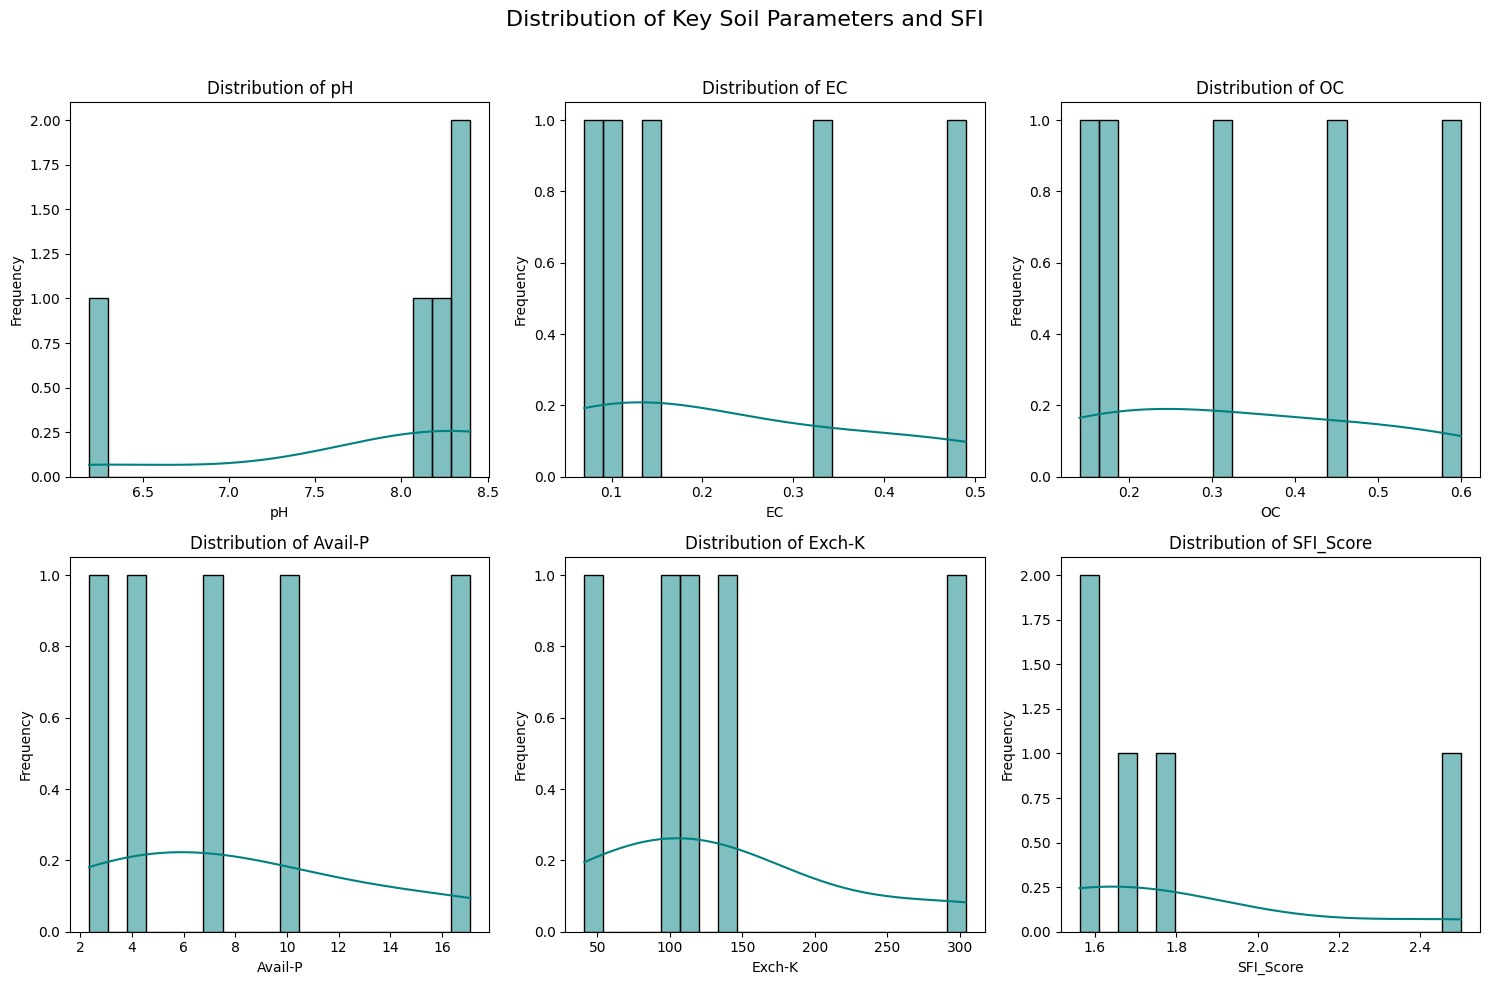

Histograms show the frequency distribution of individual parameters. This helps identify skewness and the common range of values.

--- Frequency of Top Crops ---


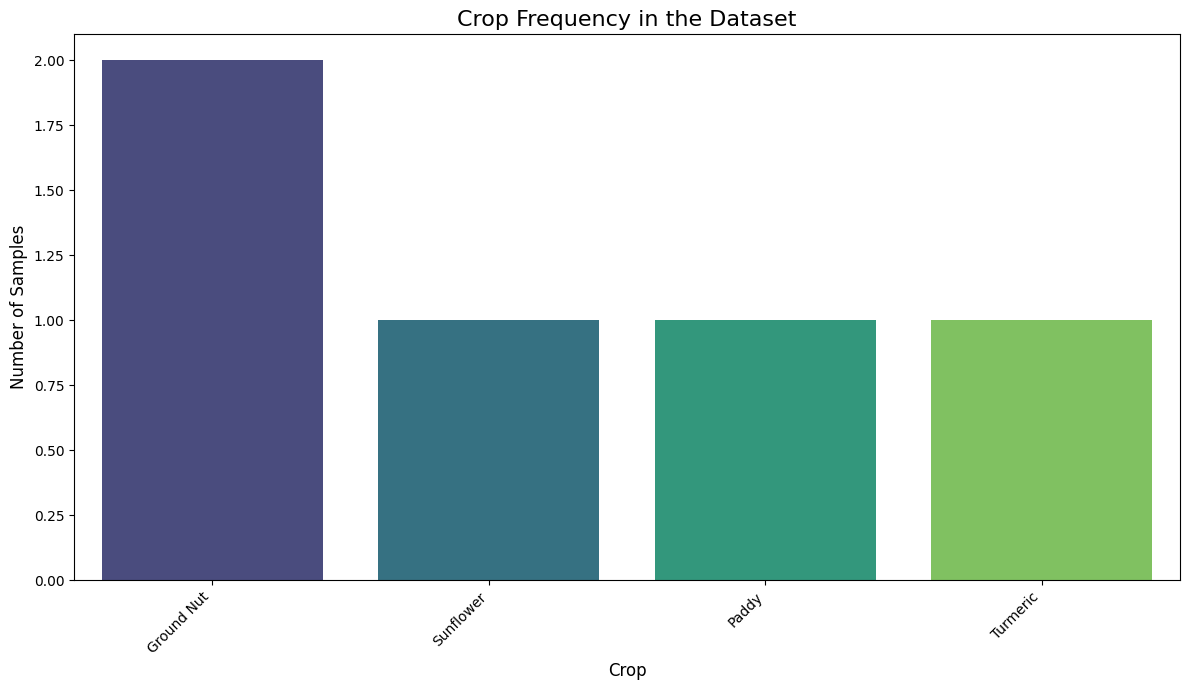

This bar chart shows the frequency of cultivated crops in your dataset.

--- Correlation Heatmap of Numerical Features ---


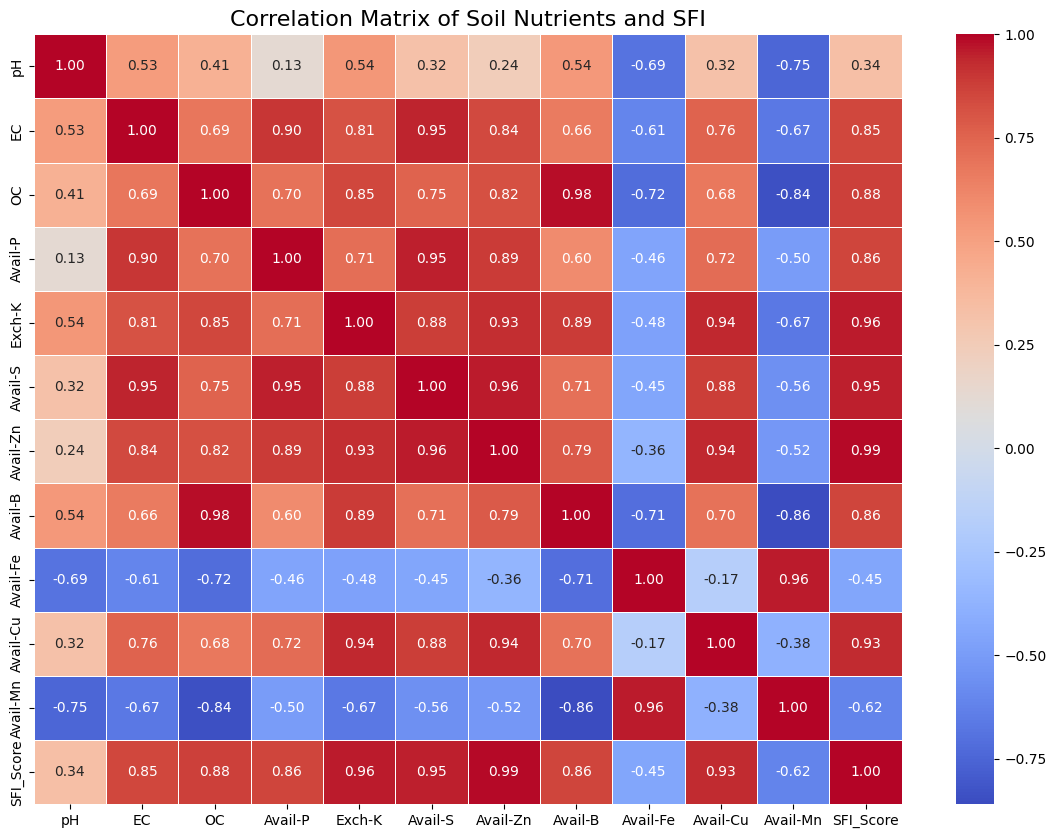

The heatmap visualizes the correlation between numerical variables. Values near +1 (red) indicate a strong positive correlation, while values near -1 (blue) indicate a strong negative correlation. Values near 0 suggest little to no linear relationship.

--- pH and OC Levels by SFI Category ---


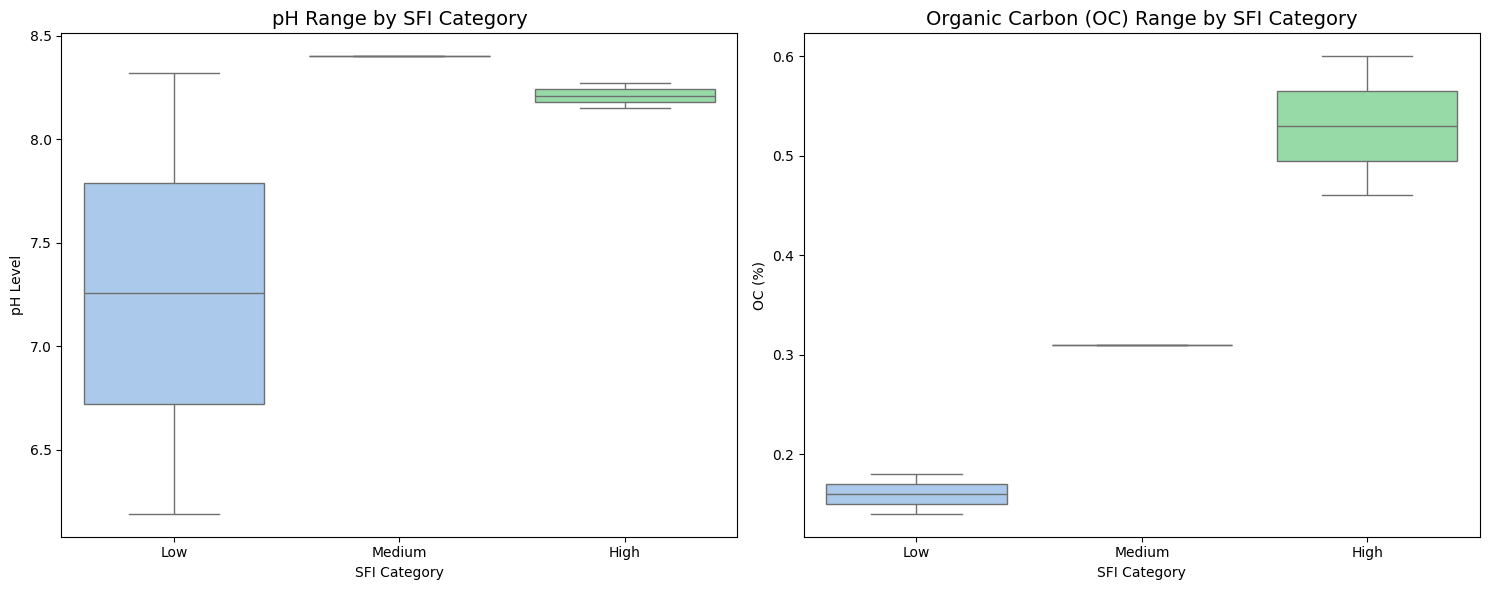

These boxplots show the distribution of pH and Organic Carbon across different SFI categories.

--- Relationship between Organic Carbon (OC) and Available Phosphorus (Avail-P) ---


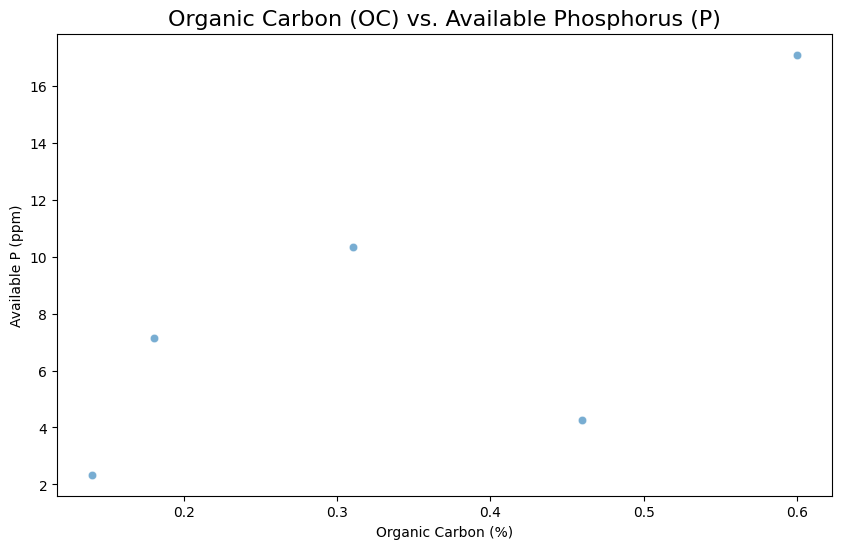

This scatter plot helps visualize the relationship between two specific nutrients. Often, higher organic carbon content can improve the availability of other nutrients.

--- Geospatial Analysis Skipped (Limited Sample Data) ---
Geospatial plots for District and Rainfall distribution are skipped as the provided sample data does not contain sufficient information for meaningful visualization.


--- EDA Concluded ---


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np # Import numpy for isnull and other operations
import io # Import io for StringIO
import re # Import re for cleaning

# Define data loading and SFI calculation functions (copied from cell Upr1ocXZKkPh for self-containment)
# --- Main Script for Soil Fertility Index ---

# Standardize Soil Type (Copied from Upr1ocXZKkPh)
master_categories = ["Black", "Red", "Sandy", "Loam", "Clay", "Brown", "Yellow", "White", "Laterite", "Saline", "Alkaline", "Alluvial", "Gravel/Stony", "Mixed", "Other"]
direct_map = {"res": "Red", "redsoil": "Red", "red sandy loam": "Red", "sandi soil": "Sandy", "rock soil": "Gravel/Stony"}
overrides = {"nalla regadi": "Black", "chowdu": "Saline", "erra maska": "Red"}

def clean_text(txt: str) -> str:
    if not isinstance(txt, str): return ""
    txt = txt.lower().strip()
    txt = re.sub(r"soil", "", txt)
    txt = re.sub(r"[^a-z\s\+\-]", "", txt)
    return txt.strip()

def standardize_soil(raw: str) -> str:
    if not raw or not isinstance(raw, str) or not raw.strip(): return "Other"
    text = clean_text(raw)
    if not text: return "Other"
    for key, val in overrides.items():
        if key in text: return val
    if text in direct_map: return direct_map[text]
    # Simplified fuzzy match for demonstration
    for cat in master_categories:
        if cat.lower() in text: return cat
    return "Other"


def load_and_clean_data(csv_data: str) -> pd.DataFrame:
    """Loads CSV data from a string, cleans column names, and standardizes soil types."""

    df = pd.read_csv(io.StringIO(csv_data))

    # 1. Clean Column Names - Preserve '-' in nutrient names
    clean_cols = {}
    for col in df.columns:
        new_col = col.strip().replace(' ', '_').replace('.', '').replace('\n', '').replace('(', '').replace(')', '')
        # Special handling for nutrient columns with '-'
        if 'Avail-' in col or 'Exch-' in col or 'NORMAL_RAINFALL' in new_col:
             new_col = col.strip().replace(' ', '_').replace('.', '').replace('\n', '').replace('(', '').replace(')', '')
        clean_cols[col] = new_col
    df = df.rename(columns=clean_cols)


    # 2. Standardize Soil Type
    df['Soil_Type_Standard'] = df['Soil_type'].apply(standardize_soil)

    # 3. Convert nutrient columns to numeric, coercing errors to NaN
    nutrient_cols = ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn']
    for col in nutrient_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

# Define nutrient sufficiency levels and ratings (Copied from Upr1ocXZKkPh)
nutrient_sufficiency = {
    'OC':       {'low': 0.5, 'medium': 0.75},  # Organic Carbon (%)
    'Avail-P':  {'low': 10,  'medium': 25},    # Available Phosphorus (kg/ha or ppm, assumes ppm)
    'Exch-K':   {'low': 120, 'medium': 280},   # Exchangeable Potassium (kg/ha or ppm, assumes ppm)
    'Avail-S':  {'low': 10,  'medium': 20},    # Available Sulphur (ppm)
    'Avail-Zn': {'low': 0.6, 'medium': 1.2},   # Available Zinc (ppm)
    'Avail-B':  {'low': 0.5, 'medium': 1.0}    # Available Boron (ppm)
}

# Define the new weights for SFI calculation (Copied from Upr1ocXZKkPh)
sfi_weights = {
    'pH': 0.10,
    'EC': 0.05,
    'OC': 0.15,
    'Avail-P': 0.10,
    'Exch-K': 0.10,
    'Avail-S': 0.05,
    'Avail-Ca': 0.05,
    'Avail-Mg': 0.05,
    'Avail-Zn': 0.05,
    'Avail-B': 0.05,
    'Avail-Fe': 0.05,
    'Avail-Cu': 0.05,
    'Avail-Mn': 0.05,
}

# Define scoring function for pH (Optimal is Medium rating = score 3) (Copied from Upr1ocXZKkPh)
def rate_ph_score(ph):
    if pd.isna(ph): return np.nan
    if 6.5 <= ph <= 7.5: return 3 # Optimal
    elif (5.5 <= ph < 6.5) or (7.5 < ph <= 8.5): return 2 # Sub-optimal
    else: return 1 # Problematic

# Define scoring function for EC (Inverse scoring - Low EC is best = score 3) (Copied from Upr1ocXZKkPh)
def rate_ec_score(ec):
    if pd.isna(ec): return np.nan
    if ec <= 1.0: return 3 # Low EC (Optimal)
    elif 1.0 < ec <= 3.0: return 2 # Medium EC (Sub-optimal)
    else: return 1 # High EC (Problematic)

# Step 2: Create a function to assign a rating based on sufficiency levels (Copied from Upr1ocXZKkPh)
def get_rating(value, limits):
    """Assigns a rating of 1 (Low), 2 (Medium), or 3 (High) to a nutrient value."""
    if pd.isna(value):
        return np.nan  # Return NaN if value is missing
    if value <= limits['low']:
        return 1  # Low
    elif value <= limits['medium']:
        return 2  # Medium
    else:
        return 3  # High

def calculate_sfi(df: pd.DataFrame) -> pd.DataFrame:
    """Calculates and categorizes the Soil Fertility Index for the DataFrame using weights."""

    # Create rating columns for each nutrient included in weights
    rating_cols = []
    for nutrient, weight in sfi_weights.items():
        rating_col_name = f'{nutrient}_rating'
        if nutrient in df.columns:
            if nutrient == 'pH':
                df[rating_col_name] = df[nutrient].apply(lambda x: rate_ph_score(x))
            elif nutrient == 'EC':
                df[rating_col_name] = df[nutrient].apply(lambda x: rate_ec_score(x))
            elif nutrient in nutrient_sufficiency:
                 df[rating_col_name] = df[nutrient].apply(lambda x: get_rating(x, nutrient_sufficiency[nutrient]))
            # Add other nutrient ratings if needed based on placeholder_sufficiency or other logic
            elif nutrient in ['Avail-Ca', 'Avail-Mg', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn']:
                 placeholder_sufficiency = {
                     'Avail-Ca': {'low': 800, 'medium': 2000},
                     'Avail-Mg': {'low': 180, 'medium': 500},
                     'Avail-Fe': {'low': 4.5, 'medium': 9.0},
                     'Avail-Cu': {'low': 0.2, 'medium': 0.4},
                     'Avail-Mn': {'low': 2.0, 'medium': 4.0},
                 }
                 if nutrient in placeholder_sufficiency:
                      df[rating_col_name] = df[nutrient].apply(lambda x: get_rating(x, placeholder_sufficiency[nutrient]))

            # Add the rating column to the list if it was created
            if rating_col_name in df.columns:
                rating_cols.append(rating_col_name)


    # Calculate the weighted SFI Score
    df['SFI_Score'] = 0
    for col in rating_cols:
        nutrient_name = col.replace('_rating', '')
        if nutrient_name in sfi_weights and col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce') # Ensure rating column is numeric
            # Only add to SFI_Score if the rating is not NaN
            df['SFI_Score'] += df[col].fillna(0) * sfi_weights[nutrient_name]


    # Re-calculating total_weight based on available ratings per row for accurate normalization
    df['SFI_Score_Sum'] = df['SFI_Score'].copy() # Store the sum before normalization
    df['Total_Weight_Per_Row'] = 0
    for col in rating_cols:
         nutrient_name = col.replace('_rating', '')
         if nutrient_name in sfi_weights and col in df.columns:
              # Add the weight if the rating is not NaN for this row
              df['Total_Weight_Per_Row'] += df[col].notna() * sfi_weights[nutrient_name]


    # Normalize SFI Score by the actual sum of weights for available nutrients in that row
    df['SFI_Score'] = df['SFI_Score_Sum'] / df['Total_Weight_Per_Row'].replace(0, np.nan) # Replace 0 with NaN to avoid division by zero

    # Drop the temporary sum and total weight columns
    df = df.drop(columns=['SFI_Score_Sum', 'Total_Weight_Per_Row'])


    # Categorize the SFI score (adjust bins if the weighted score range changes)
    # Using quantiles for categorization to handle varying score ranges
    if df['SFI_Score'].dropna().shape[0] >= 3: # Need at least 3 non-null values for 2 quantiles
        try:
            sfi_bins = [df['SFI_Score'].min() - 0.01, df['SFI_Score'].quantile(0.33), df['SFI_Score'].quantile(0.66), df['SFI_Score'].max() + 0.01]
            # Ensure bins are unique and increasing
            unique_bins = sorted(list(set(sfi_bins)))
            if len(unique_bins) >= 2:
                 df['SFI_Category'] = pd.cut(df['SFI_Score'], bins=unique_bins, labels=['Low', 'Medium', 'High'][:len(unique_bins)-1], right=True)
            else:
                 df['SFI_Category'] = 'Unknown' # Cannot categorize if bins are not distinct enough
        except Exception as e:
             print(f"Error during SFI categorization: {e}")
             df['SFI_Category'] = 'Unknown'
    else:
         df['SFI_Category'] = 'Unknown' # Cannot categorize if not enough data


    return df


# --- Data Loading and SFI Calculation within this cell ---
csv_data = """
Sl no,Date,Farmer Name,Latitude,Longitude,Soil type,Crop before,pH,EC,OC,Avail-P,Exch-K,Avail-S,Avail-Zn,Avail-B,Avail-Fe,Avail-Cu,Avail-Mn,Season
1,1/1/2015,P.Krishna Naik,14.08,77.69,Mixed soil,Ground Nut,6.19,0.07,0.18,7.13,41,5.16,0.30,0.17,8.89,0.51,15.24,Kharif & Rabi
2,1/1/2015,Kallu Thippe Naik,14.09,77.69,Redsoil,Ground Nut,8.4,0.33,0.31,10.34,102,9.91,0.36,0.57,3.24,0.44,6.90,Kharif & Rabi
164,1/1/2015,M.Sathyanarayana,14.54,77.55,BLACK,Sunflower,8.32,0.14,0.14,2.34,116,4.48,0.19,0.32,8.02,1.05,12.62,Perennial
166,1/1/2015,G.Laxmi Narayana,14.54,77.54,BLACK,Paddy,8.15,0.11,0.46,4.27,140,4.65,0.37,1.06,4.17,0.66,6.50,Kharif & Rabi
1,1/1/2015,K Venkata Ratnam,16.24,80.79,Black soil,Turmeric,8.27,0.49,0.60,17.10,304,21.65,1.62,1.36,4.53,2.80,6.07,Perennial
"""

df_sfi = load_and_clean_data(csv_data)
df_sfi = calculate_sfi(df_sfi) # Calculate SFI

# Use the processed dataframe with SFI
df_analysis = df_sfi.copy()

print("\n--- Missing Values (Relevant Columns for EDA) ---")
# Check missing values on the relevant columns for EDA
# Ensure column names are correct based on df_sfi
eda_cols_check = ['Crop_before', 'Soil_Type_Standard', 'pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn', 'SFI_Score']
missing_data = df_analysis[[col for col in eda_cols_check if col in df_analysis.columns]].isnull().sum()
print(missing_data.sort_values(ascending = False))


# --- UNIVARIATE ANALYSIS (ANALYZING SINGLE VARIABLES) ---

print("\n--- Distribution of Key Numerical Features ---")
plt.figure(figsize=(15, 10))
plt.suptitle("Distribution of Key Soil Parameters and SFI", fontsize=16)
# Use cleaned and relevant numerical column names from df_analysis
key_features = ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'SFI_Score']
# Ensure these columns exist and are numeric in df_analysis
numerical_eda_cols = [col for col in key_features if col in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis[col])]

for i, feature in enumerate(numerical_eda_cols, 1):
    if i > 6: break # Limit to 6 subplots as per figure size
    plt.subplot(2, 3, i)
    sns.histplot(df_analysis[feature].dropna(), kde=True, bins=20, color='teal') # Dropna for plotting
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
print("Histograms show the frequency distribution of individual parameters. This helps identify skewness and the common range of values.")

print("\n--- Frequency of Top Crops ---")
plt.figure(figsize=(12, 7))
# Use the cleaned crop column name
if 'Crop_before' in df_analysis.columns:
    top_crops = df_analysis['Crop_before'].value_counts() # Using all unique crops in the sample
    if not top_crops.empty:
        sns.barplot(x=top_crops.index, y=top_crops.values, palette='viridis')
        plt.title('Crop Frequency in the Dataset', fontsize=16)
        plt.xlabel('Crop', fontsize=12)
        plt.ylabel('Number of Samples', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        print("This bar chart shows the frequency of cultivated crops in your dataset.")
    else:
        print("No crop data available for frequency analysis.")
else:
    print("'Crop_before' column not found for frequency analysis.")


# --- BIVARIATE ANALYSIS (RELATIONSHIPS BETWEEN TWO VARIABLES) ---

print("\n--- Correlation Heatmap of Numerical Features ---")
plt.figure(figsize=(14, 10))
# Select relevant numerical columns for correlation analysis
# Ensure these columns exist and are numeric
correlation_cols = ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn', 'SFI_Score']
numerical_corr_cols = [col for col in correlation_cols if col in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis[col])]

if numerical_corr_cols and len(numerical_corr_cols) > 1: # Need at least two columns for correlation
    corr_matrix = df_analysis[numerical_corr_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Correlation Matrix of Soil Nutrients and SFI', fontsize=16)
    plt.show()
    print("The heatmap visualizes the correlation between numerical variables. Values near +1 (red) indicate a strong positive correlation, while values near -1 (blue) indicate a strong negative correlation. Values near 0 suggest little to no linear relationship.")
elif numerical_corr_cols:
    print(f"Only one numerical column ({numerical_corr_cols[0]}) available for correlation heatmap.")
else:
    print("No numerical columns available for correlation heatmap.")


print("\n--- pH and OC Levels by SFI Category ---")
# Ensure columns exist
if all(col in df_analysis.columns for col in ['SFI_Category', 'pH', 'OC']):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df_analysis, x='SFI_Category', y='pH', order=['Low', 'Medium', 'High'], palette='pastel')
    plt.title('pH Range by SFI Category', fontsize=14)
    plt.xlabel('SFI Category')
    plt.ylabel('pH Level')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_analysis, x='SFI_Category', y='OC', order=['Low', 'Medium', 'High'], palette='pastel')
    plt.title('Organic Carbon (OC) Range by SFI Category', fontsize=14)
    plt.xlabel('SFI Category')
    plt.ylabel('OC (%)')
    plt.tight_layout()
    plt.show()
    print("These boxplots show the distribution of pH and Organic Carbon across different SFI categories.")
else:
     print("'SFI_Category', 'pH', or 'OC' columns missing for analysis by SFI Category.")


print("\n--- Relationship between Organic Carbon (OC) and Available Phosphorus (Avail-P) ---")
# Ensure columns exist and are numeric
if 'OC' in df_analysis.columns and 'Avail-P' in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis['OC']) and pd.api.types.is_numeric_dtype(df_analysis['Avail-P']):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_analysis, x='OC', y='Avail-P', alpha=0.6)
    plt.title('Organic Carbon (OC) vs. Available Phosphorus (P)', fontsize=16)
    plt.xlabel('Organic Carbon (%)')
    plt.ylabel('Available P (ppm)')
    plt.show()
    print("This scatter plot helps visualize the relationship between two specific nutrients. Often, higher organic carbon content can improve the availability of other nutrients.")
else:
    print("'OC' or 'Avail-P' columns missing or not numeric for scatter plot.")


# --- GEOSPATIAL ANALYSIS (Skipped due to limited sample data) ---
print("\n--- Geospatial Analysis Skipped (Limited Sample Data) ---")
print("Geospatial plots for District and Rainfall distribution are skipped as the provided sample data does not contain sufficient information for meaningful visualization.")


print("\n\n--- EDA Concluded ---")


--- Columns available for analysis: ['District', 'Latitude', 'Longitude', 'pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn'] ---

--- Data cleaned. Started with 4816 rows, working with 4815 rows after dropping NaNs in ['District', 'Latitude', 'Longitude']. ---

--- 3.1. Missing Values (after dropping for analysis) ---
District     0
Latitude     0
Longitude    0
pH           0
EC           0
OC           0
Avail-P      0
Exch-K       0
Avail-S      0
Avail-Zn     0
Avail-B      0
Avail-Fe     0
Avail-Cu     0
Avail-Mn     0
dtype: int64

--- 3.2. Statistical Overview ---
This summary provides a quick look at the central tendency, dispersion, and shape of the dataset's distribution.
         Sl no  Latitude  Longitude       pH       EC       OC  Avail-P  \
count  4815.00   4815.00    4815.00  4815.00  4815.00  4815.00  4815.00   
mean    208.07     15.93      80.48     7.48     0.49     0.48    16.70   
std     129.35      1.74 

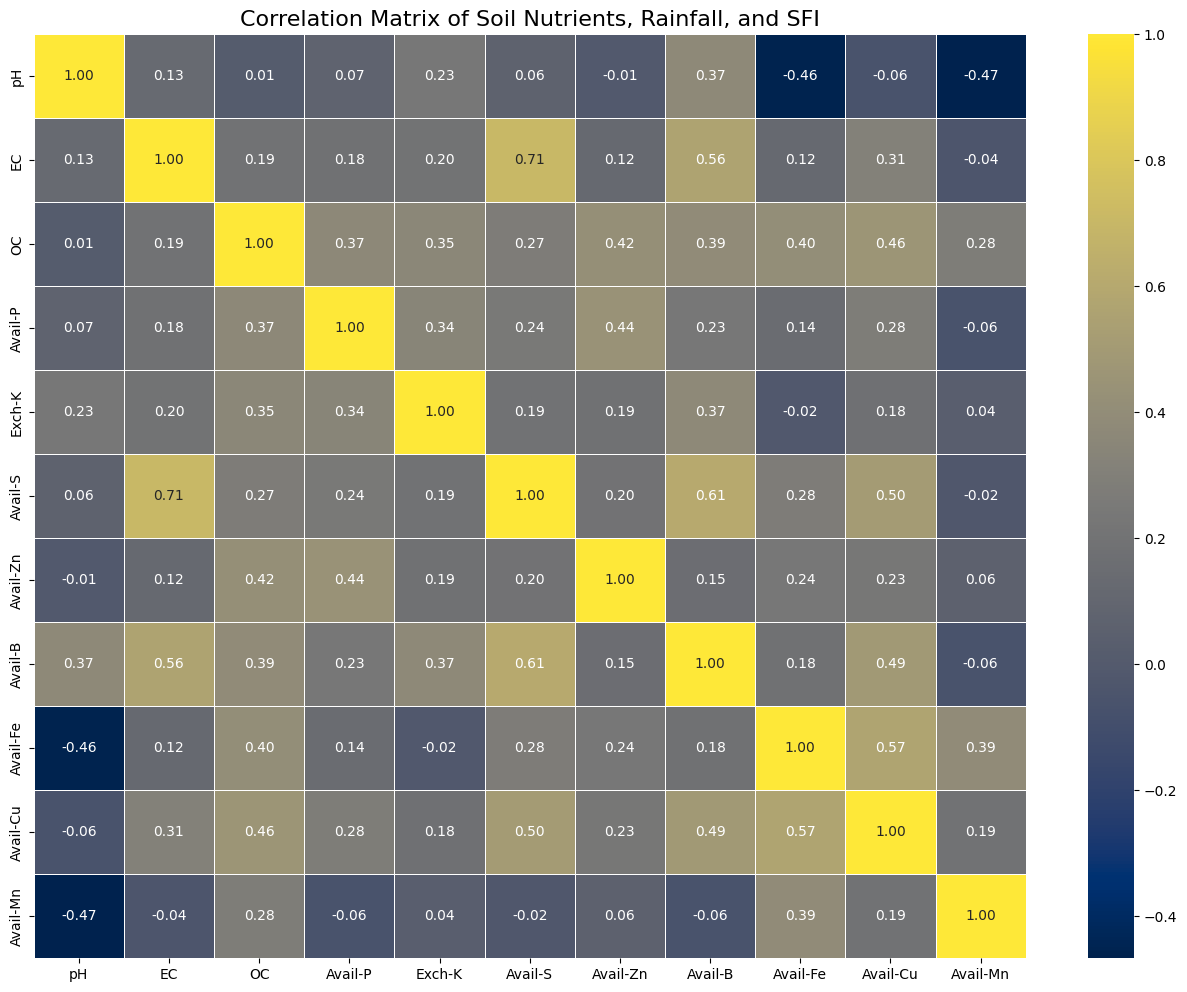

The heatmap shows correlations between all numerical variables. Look at the rainfall row/column to see how rainfall correlates with soil properties. For example, a negative correlation with certain nutrients might suggest leaching in high-rainfall areas.

--- 3.7. Geospatial Analysis: Rainfall Map ---
'Longitude', 'Latitude', or 'ANNUAL_NORMAL_RAINFALL_Millimeters' columns not found or 'ANNUAL_NORMAL_RAINFALL_Millimeters' not numeric for Rainfall Map plot.


--- EDA Concluded ---


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Use the merged dataframe which contains all the data, including rainfall.
# Assuming merged_df is available from earlier steps in the notebook.
df_analysis = merged_df.copy()

# --- Preprocessing Step ---
# Ensure necessary columns for this analysis exist in merged_df
required_cols_for_analysis = ['Crop_before', 'District', 'ANNUAL_NORMAL_RAINFALL_Millimeters', 'Latitude', 'Longitude', 'pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn', 'SFI_Score', 'SFI_Category']
# Filter to columns actually present in df_analysis
present_analysis_cols = [col for col in required_cols_for_analysis if col in df_analysis.columns]

print(f"\n--- Columns available for analysis: {present_analysis_cols} ---")


# Drop rows where essential data for THIS analysis is missing
# Based on the KeyErrors, the issue was with attempting to drop using nonexistent columns.
# We will use the columns that are expected to be crucial for the plots below.
cols_to_dropna = ['Crop_before', 'District', 'ANNUAL_NORMAL_RAINFALL_Millimeters', 'Latitude', 'Longitude']
# Only use columns present in the dataframe for dropping
present_dropna_cols = [col for col in cols_to_dropna if col in df_analysis.columns]

if present_dropna_cols:
    initial_rows = len(df_analysis)
    df_analysis.dropna(subset=present_dropna_cols, inplace=True)
    print(f"\n--- Data cleaned. Started with {initial_rows} rows, working with {len(df_analysis)} rows after dropping NaNs in {present_dropna_cols}. ---")
else:
    print("\n--- No specified columns available for dropping rows with missing values. ---")


# --- 3. EXPLORATORY DATA ANALYSIS & VISUALIZATION ---

print("\n--- 3.1. Missing Values (after dropping for analysis) ---")
# Check missing values again after dropping
missing_data = df_analysis[present_analysis_cols].isnull().sum()
print(missing_data.sort_values(ascending = False))


print("\n--- 3.2. Statistical Overview ---")
# Select only numerical columns for describe
numerical_cols = df_analysis.select_dtypes(include=np.number).columns
print("This summary provides a quick look at the central tendency, dispersion, and shape of the dataset's distribution.")
print(df_analysis[numerical_cols].describe().round(2))


# --- Distribution of Rainfall ---
print("\n--- 3.3. Univariate Analysis: Rainfall Distribution ---")
# Check if rainfall column exists before plotting
rainfall_col = 'ANNUAL_NORMAL_RAINFALL_Millimeters'
if rainfall_col in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis[rainfall_col]):
    plt.figure(figsize=(12, 6))
    sns.histplot(df_analysis[rainfall_col].dropna(), kde=True, bins=30, color='royalblue')
    plt.title('Distribution of Annual Normal Rainfall Across Samples', fontsize=16)
    plt.xlabel('Annual Rainfall (mm)', fontsize=12)
    plt.ylabel('Frequency of Samples', fontsize=12)
    plt.show()
    print("The histogram above shows the frequency of different rainfall amounts. You can see which rainfall ranges are most common in your dataset.")
else:
    print(f"'{rainfall_col}' column not found or not numeric for distribution plot.")


# --- Rainfall by District ---
print("\n--- 3.4. Bivariate Analysis: Rainfall by District ---")
# Check if district and rainfall columns exist and are suitable
district_col = 'District'
if district_col in df_analysis.columns and rainfall_col in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis[rainfall_col]):
    plt.figure(figsize=(14, 8))
    # Order districts by median rainfall for better readability
    if not df_analysis[district_col].dropna().empty:
        district_order = df_analysis.groupby(district_col)[rainfall_col].median().sort_values(ascending=False).index
        # Filter to top N districts if too many for plot
        if len(district_order) > 20: # Example limit
            district_order = district_order[:20]
            df_plot = df_analysis[df_analysis[district_col].isin(district_order)].copy()
        else:
             df_plot = df_analysis.copy()

        if not df_plot.empty:
             sns.boxplot(data=df_plot, x=rainfall_col, y=district_col, order=district_order, palette='coolwarm')
             plt.title('Annual Rainfall Distribution by District', fontsize=16)
             plt.xlabel('Annual Rainfall (mm)', fontsize=12)
             plt.ylabel('District', fontsize=12)
             plt.show()
             print("This boxplot illustrates the rainfall variation across different districts, highlighting which are generally wetter or drier.")
        else:
            print("Not enough data after filtering for top districts to plot Rainfall by District.")
    else:
        print(f"'{district_col}' column has no non-null values for grouping.")
else:
    print(f"'{district_col}' or '{rainfall_col}' columns not found or '{rainfall_col}' not numeric for Rainfall by District plot.")


# --- Rainfall by Crop ---
print("\n--- 3.5. Bivariate Analysis: Rainfall by Crop ---")
# Check if crop and rainfall columns exist and are suitable
crop_col = 'Crop_before'
if crop_col in df_analysis.columns and rainfall_col in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis[rainfall_col]):
    top_10_crops = df_analysis[crop_col].value_counts().nlargest(10).index

    if not top_10_crops.empty:
        df_top10 = df_analysis[df_analysis[crop_col].isin(top_10_crops)].copy()

        if not df_top10.empty:
            plt.figure(figsize=(14, 8))
            # Order crops by their median rainfall requirement for better visualization
            crop_order = df_top10.groupby(crop_col)[rainfall_col].median().sort_values(ascending=False).index
            sns.boxplot(data=df_top10, x=rainfall_col, y=crop_col, order=crop_order, palette='crest')
            plt.title('Rainfall Distribution for Top 10 Crops', fontsize=16)
            plt.xlabel('Annual Rainfall (mm)', fontsize=12)
            plt.ylabel('Crop', fontsize=12)
            plt.show()
            print("This plot shows the rainfall ranges where different crops are grown, providing insight into their water requirements.")
        else:
            print("Not enough data after filtering for top 10 crops to plot Rainfall by Crop.")
    else:
        print(f"'{crop_col}' column has no non-null values or less than 10 unique values for Top 10 Crops analysis.")
else:
    print(f"'{crop_col}' or '{rainfall_col}' columns not found or '{rainfall_col}' not numeric for Rainfall by Crop plot.")


# --- Correlation Heatmap Including Rainfall and SFI ---
print("\n--- 3.6. Multivariate Analysis: Correlation Heatmap ---")
plt.figure(figsize=(16, 12))
# Select relevant numerical columns for correlation analysis, including rainfall and SFI if present
correlation_cols_full = ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn', rainfall_col, 'SFI_Score']
numerical_corr_cols_full = [col for col in correlation_cols_full if col in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis[col])]

if numerical_corr_cols_full and len(numerical_corr_cols_full) > 1:
    corr_matrix = df_analysis[numerical_corr_cols_full].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='cividis', fmt='.2f', linewidths=.5)
    plt.title('Correlation Matrix of Soil Nutrients, Rainfall, and SFI', fontsize=16)
    plt.show()
    print("The heatmap shows correlations between all numerical variables. Look at the rainfall row/column to see how rainfall correlates with soil properties. For example, a negative correlation with certain nutrients might suggest leaching in high-rainfall areas.")
elif numerical_corr_cols_full:
     print(f"Only one numerical column ({numerical_corr_cols_full[0]}) available for correlation heatmap.")
else:
    print("No numerical columns available for correlation heatmap.")


# --- Geospatial Plot of Rainfall ---
print("\n--- 3.7. Geospatial Analysis: Rainfall Map ---")
# Check if latitude, longitude, and rainfall columns exist and are suitable
if 'Longitude' in df_analysis.columns and 'Latitude' in df_analysis.columns and rainfall_col in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis[rainfall_col]):
    plt.figure(figsize=(12, 10))
    # Using a sequential color palette where darker means more rainfall
    scatter = plt.scatter(df_analysis['Longitude'], df_analysis['Latitude'], c=df_analysis[rainfall_col],
                          cmap='Blues', s=50, alpha=0.7,
                          edgecolor='black', linewidth=0.5)
    plt.colorbar(scatter, label='Annual Rainfall (mm)')
    plt.title('Geographical Distribution of Annual Rainfall', fontsize=16)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.grid(True)
    plt.show()
    print("This map visualizes the rainfall intensity across different geographical locations, making it easy to spot regional weather patterns.")
else:
    print(f"'Longitude', 'Latitude', or '{rainfall_col}' columns not found or '{rainfall_col}' not numeric for Rainfall Map plot.")


print("\n\n--- EDA Concluded ---")


'Dist_Name' column not found, skipping drop.

Dataframes processed for plotting.
Prepared data for plotting. Using 4816 complete samples for selected features.

--- Generating Boxplots for Each Essential Feature ---


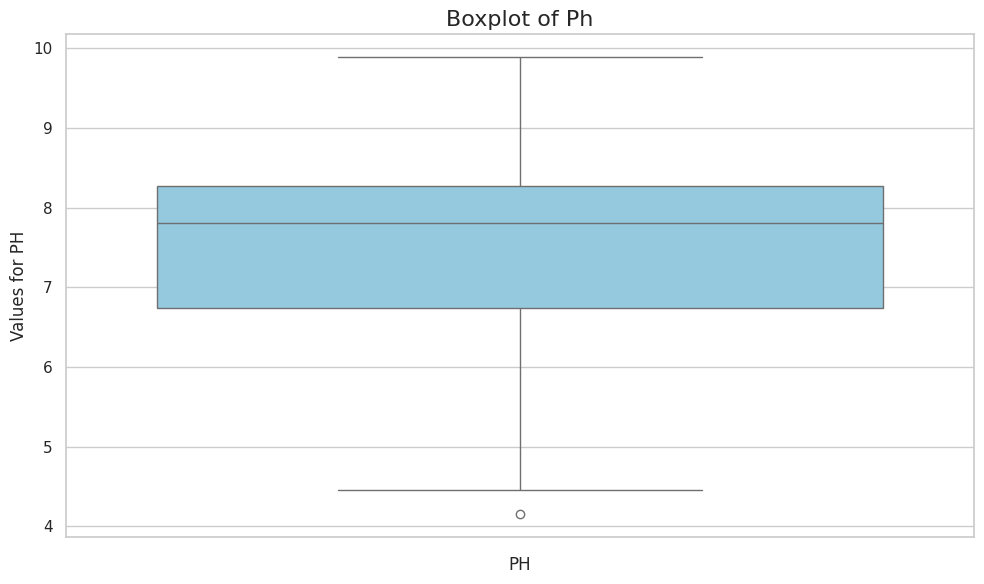

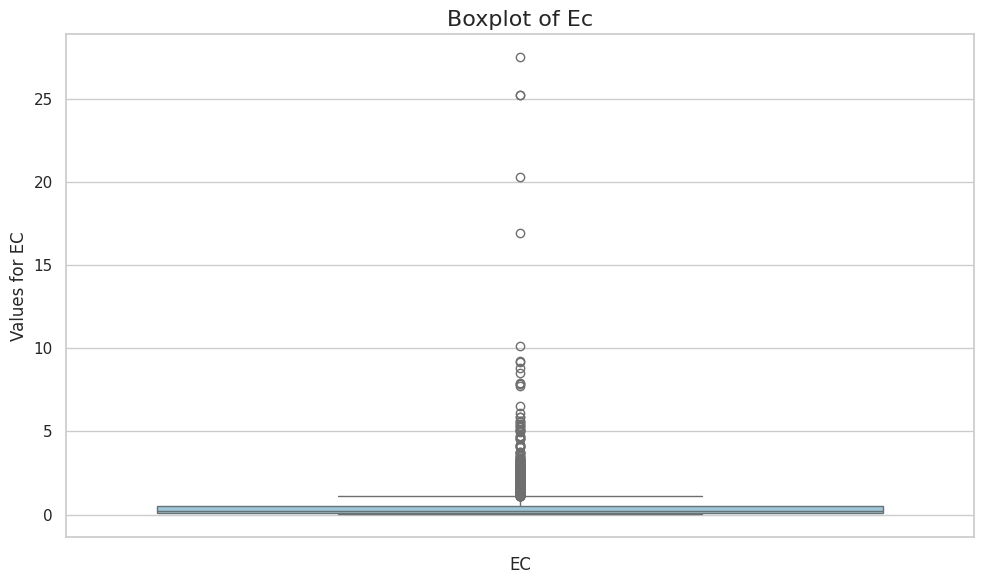

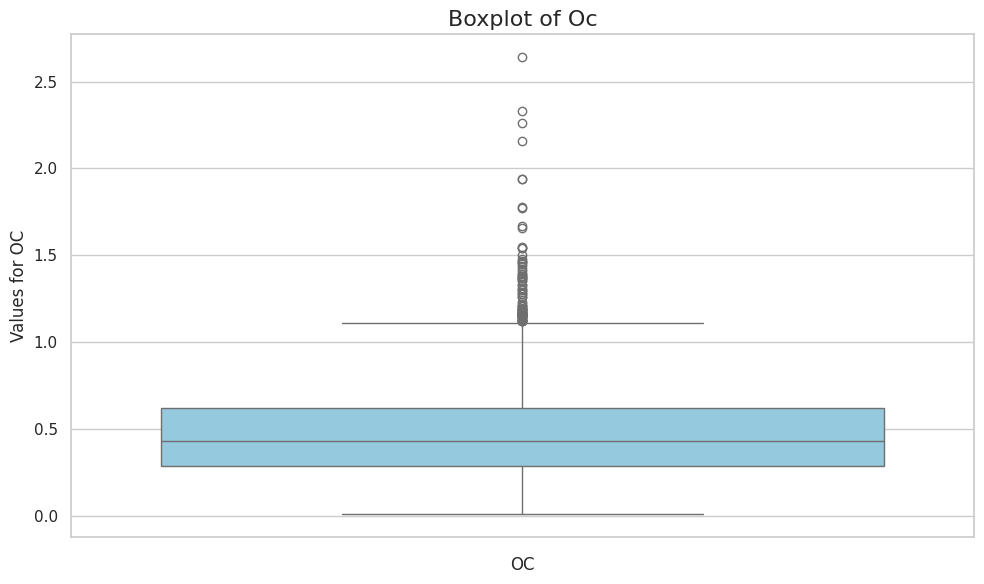

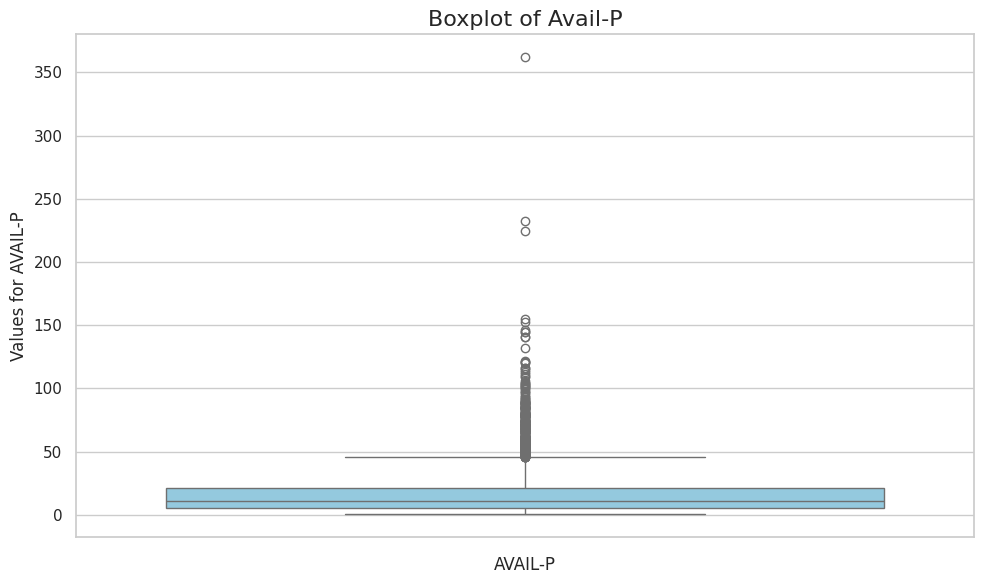

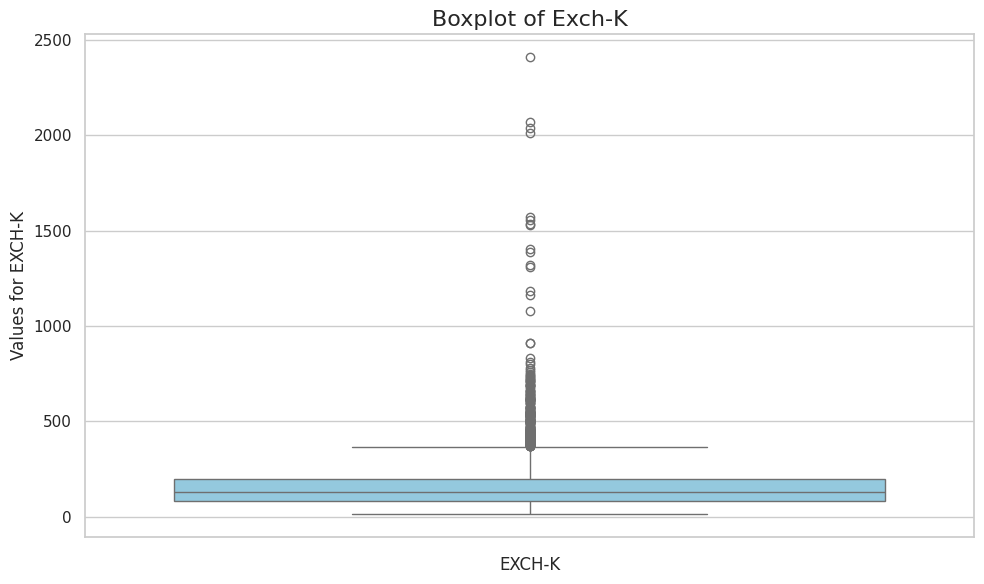

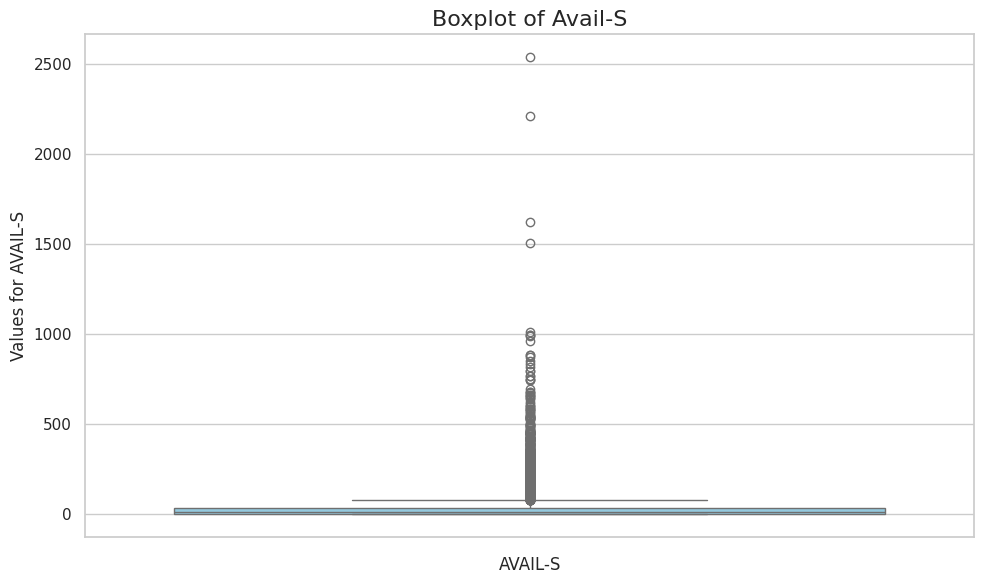

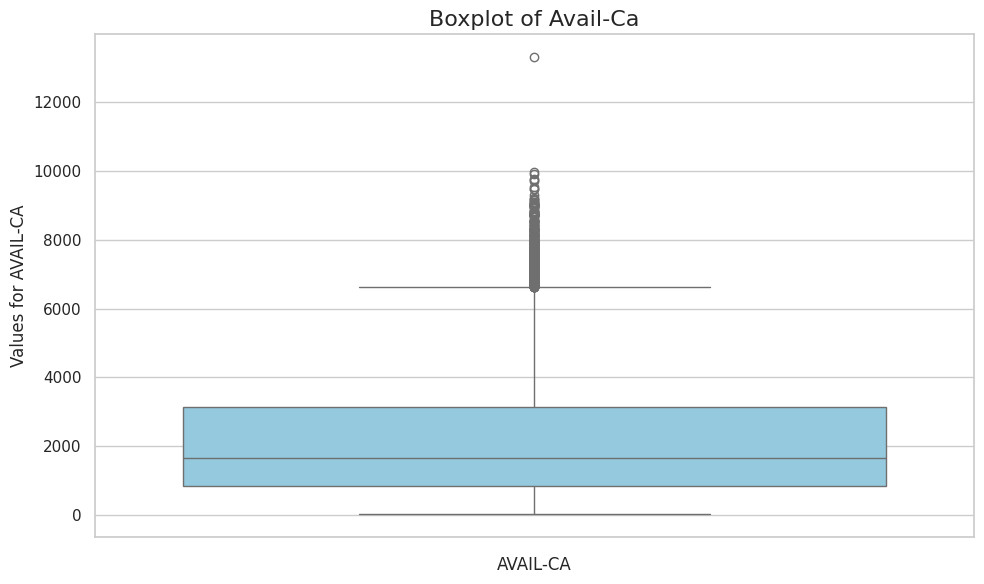

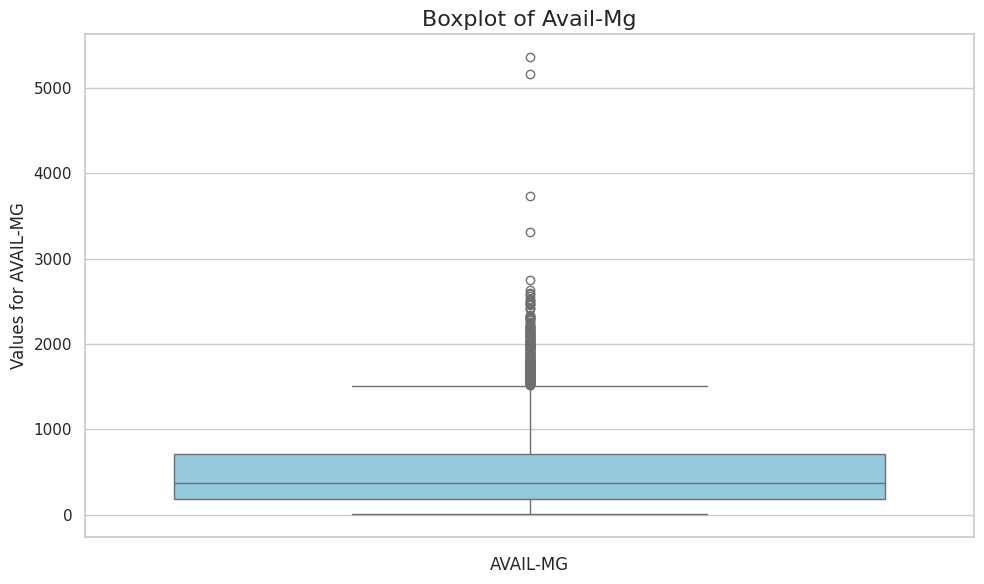

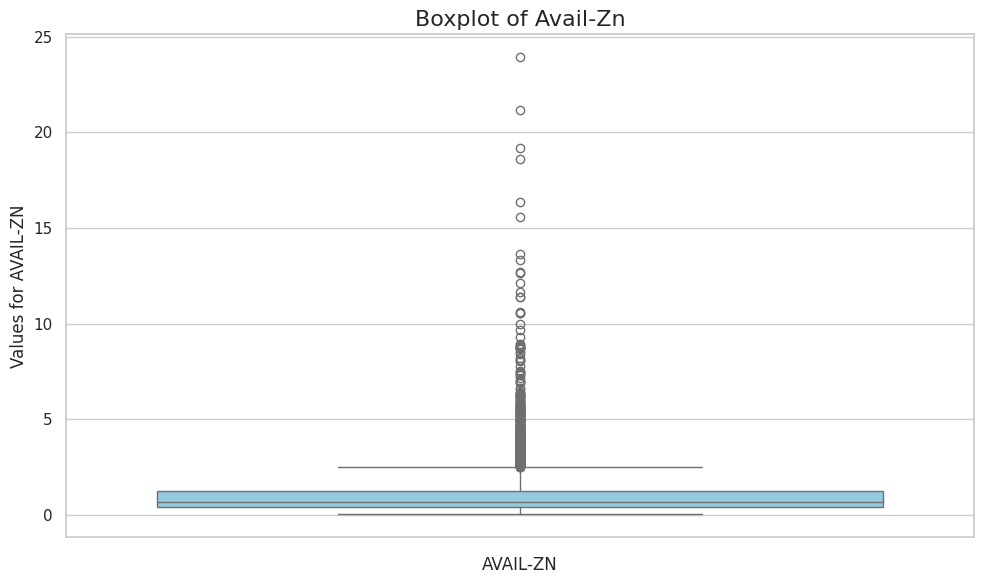

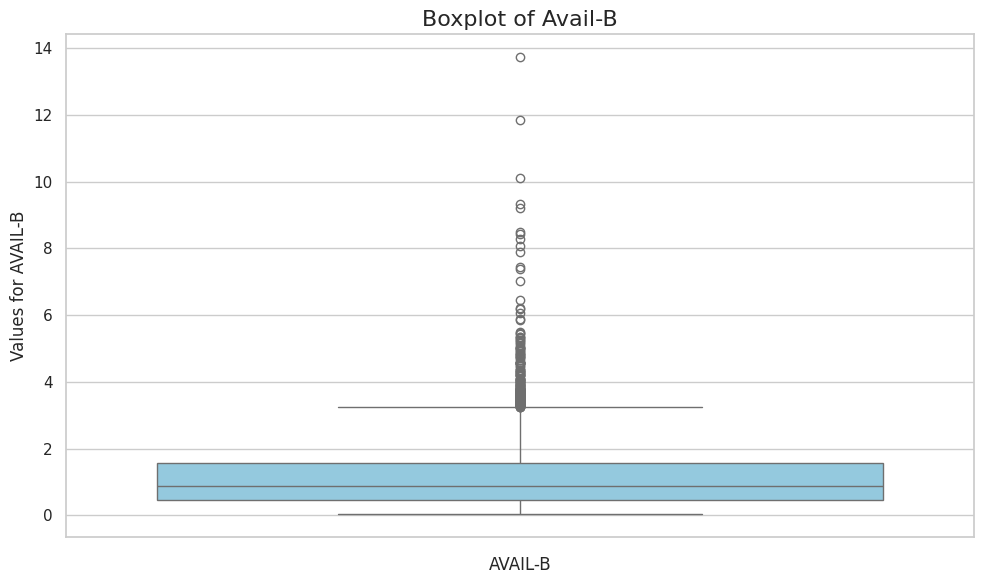

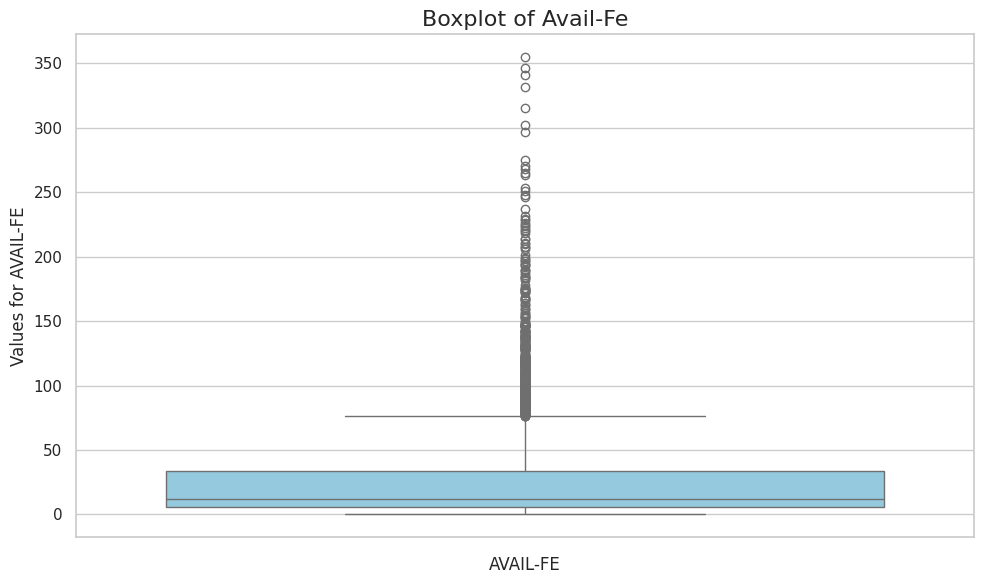

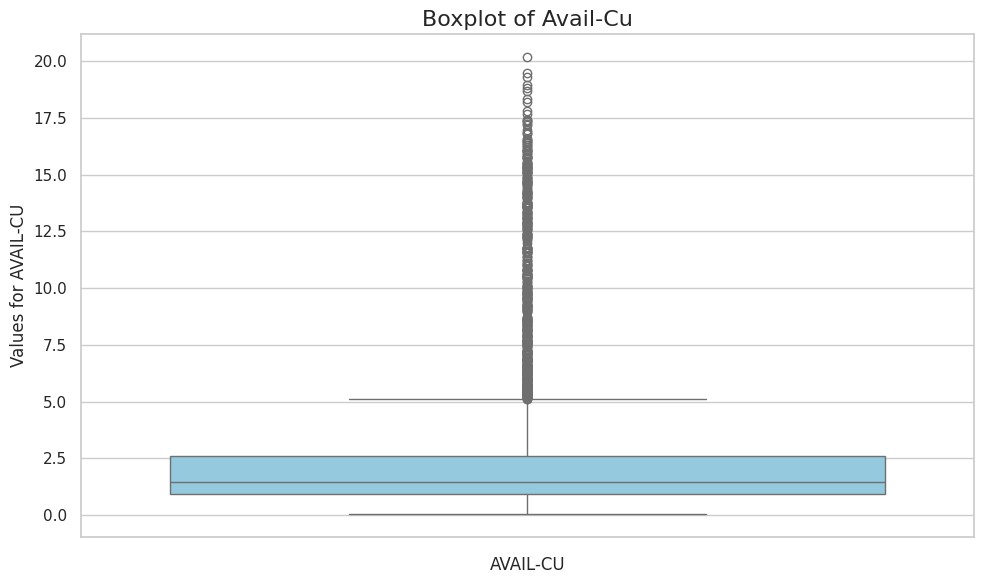

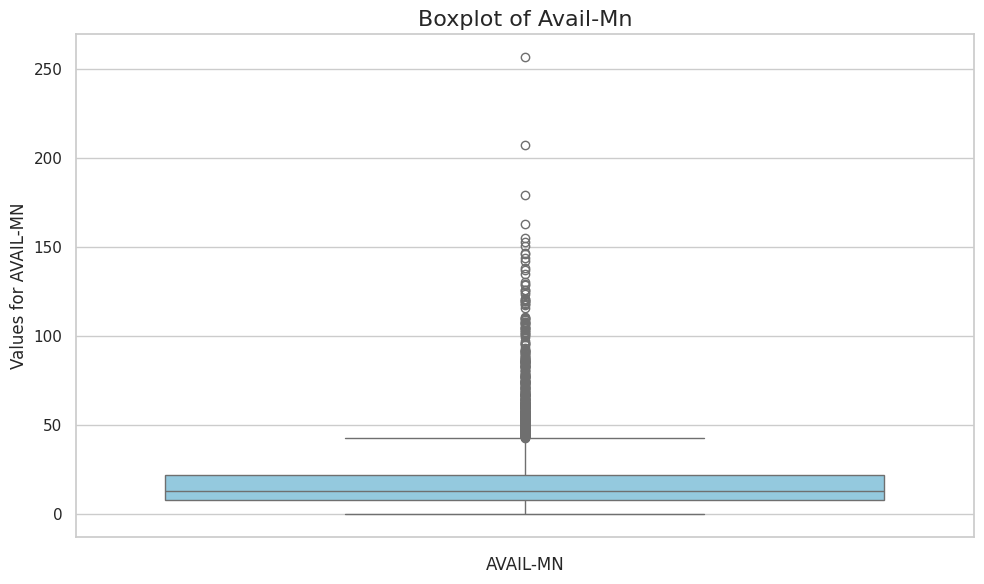


--- All boxplots have been generated. ---


In [55]:
# Assuming 'df' here is the dataframe you intend to use for plotting.
# Based on previous steps, merged_df or df_processed might be the intended dataframe.
# Let's assume 'df' refers to the dataframe you want to analyze, which should have cleaned column names.

# Final cleaning - Check if 'Dist_Name' column exists before dropping
if 'Dist_Name' in df.columns:
    df.drop(columns=['Dist_Name'], inplace=True)
    print("\n'Dist_Name' column dropped successfully.")
else:
    print("\n'Dist_Name' column not found, skipping drop.")

print("\nDataframes processed for plotting.")

# --- 3. FEATURE SELECTION AND DATA PREPARATION ---

# Define the list of essential numerical features to plot
# Ensure these column names match the cleaned names in your dataframe
features_to_plot = [
    'pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-S',
    'Avail-Ca', 'Avail-Mg', 'Avail-Zn', 'Avail-B',
    'Avail-Fe', 'Avail-Cu', 'Avail-Mn',
    'ANNUAL_NORMAL_RAINFALL_Millimeters' # Include if available and relevant
]

# Filter features_to_plot to only include columns present in df
present_features_to_plot = [col for col in features_to_plot if col in df.columns]

# Convert columns to numeric and handle potential errors
for col in present_features_to_plot:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where any of these features are missing to ensure clean plots
# Only drop if there are columns to drop based on present_features_to_plot
if present_features_to_plot:
    df_cleaned = df.dropna(subset=present_features_to_plot).copy() # Use .copy() to avoid SettingWithCopyWarning
    print(f"Prepared data for plotting. Using {len(df_cleaned)} complete samples for selected features.")
else:
    df_cleaned = df.copy() # If no features to plot, just copy the original df
    print("No numerical features selected for plotting or found in the dataframe.")


# --- 4. GENERATE AND DISPLAY BOXPLOTS ---

print("\n--- Generating Boxplots for Each Essential Feature ---")

# Loop through each feature and create a separate boxplot
for column in present_features_to_plot:
    plt.figure(figsize=(10, 6)) # Create a new figure for each plot

    # Use df_cleaned for plotting
    sns.boxplot(y=df_cleaned[column], color='skyblue')

    # Set titles and labels for clarity
    plt.title(f'Boxplot of {column.replace("_", " ").title()}', fontsize=16)
    plt.ylabel(f'Values for {column.upper()}', fontsize=12)
    plt.xlabel(column.upper(), fontsize=12) # Using column name as x-label for consistency

    # Show the plot
    plt.tight_layout()
    plt.show()

print("\n--- All boxplots have been generated. ---")


--- EDA: Distribution of Nutrients ---


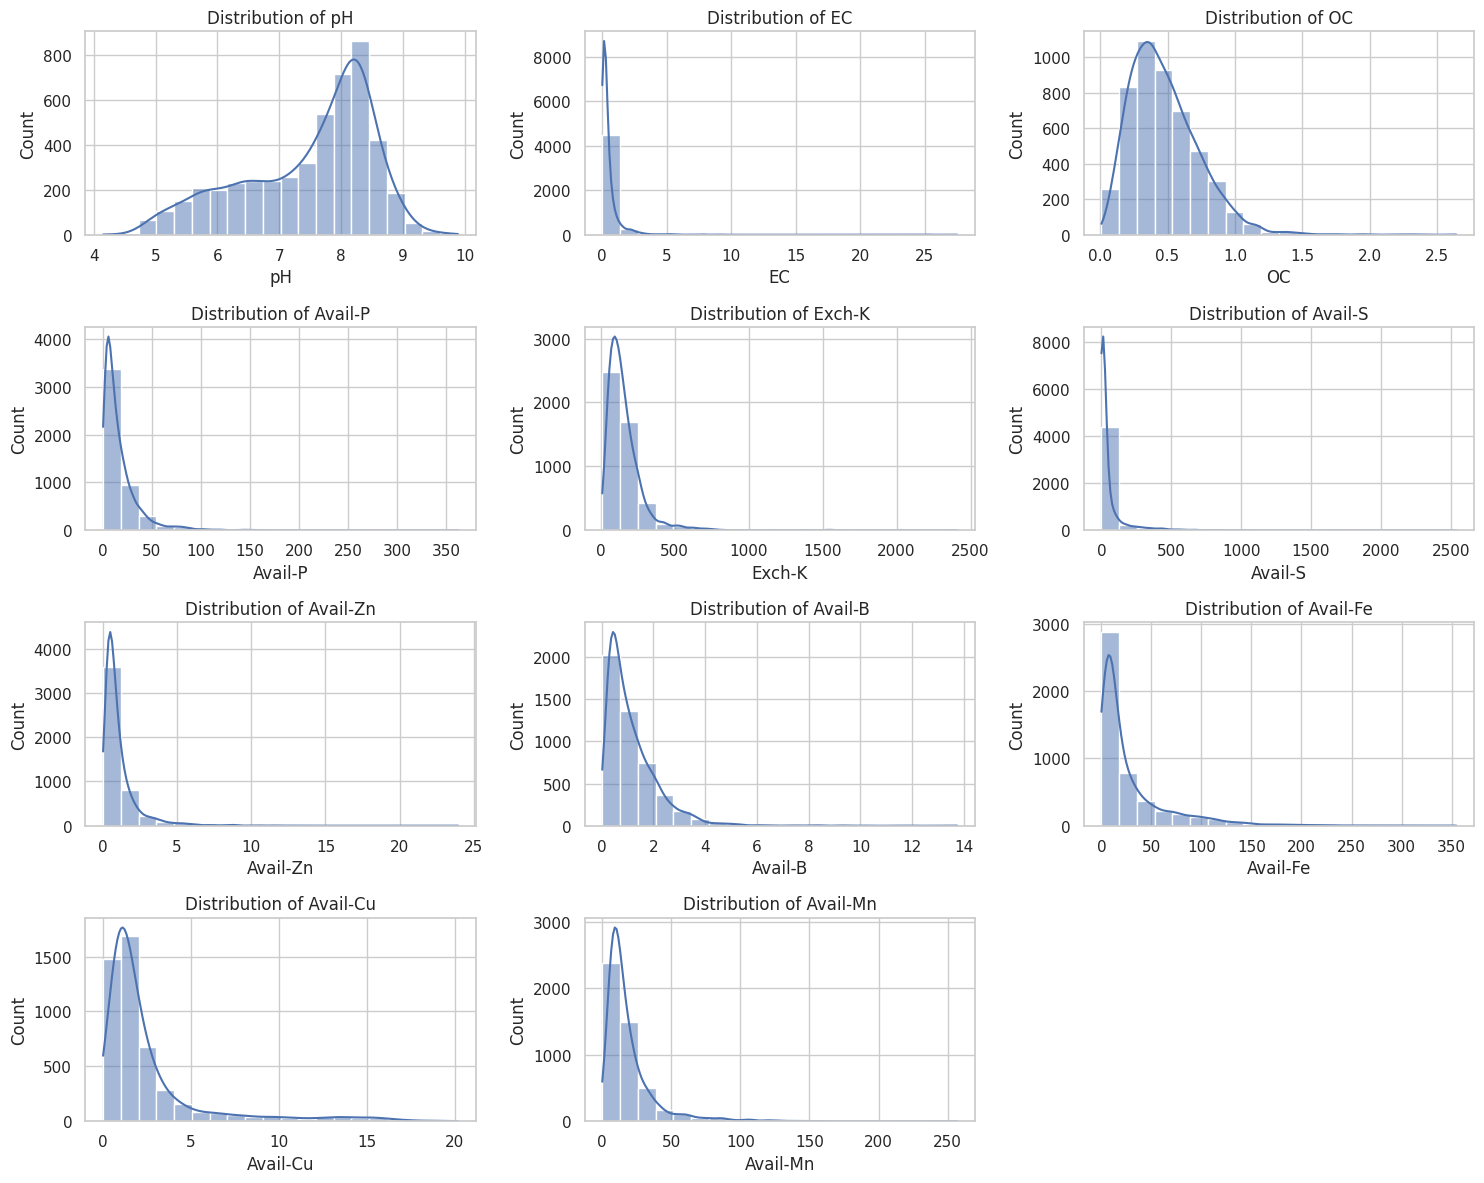


--- EDA: Class Balance Analysis ---


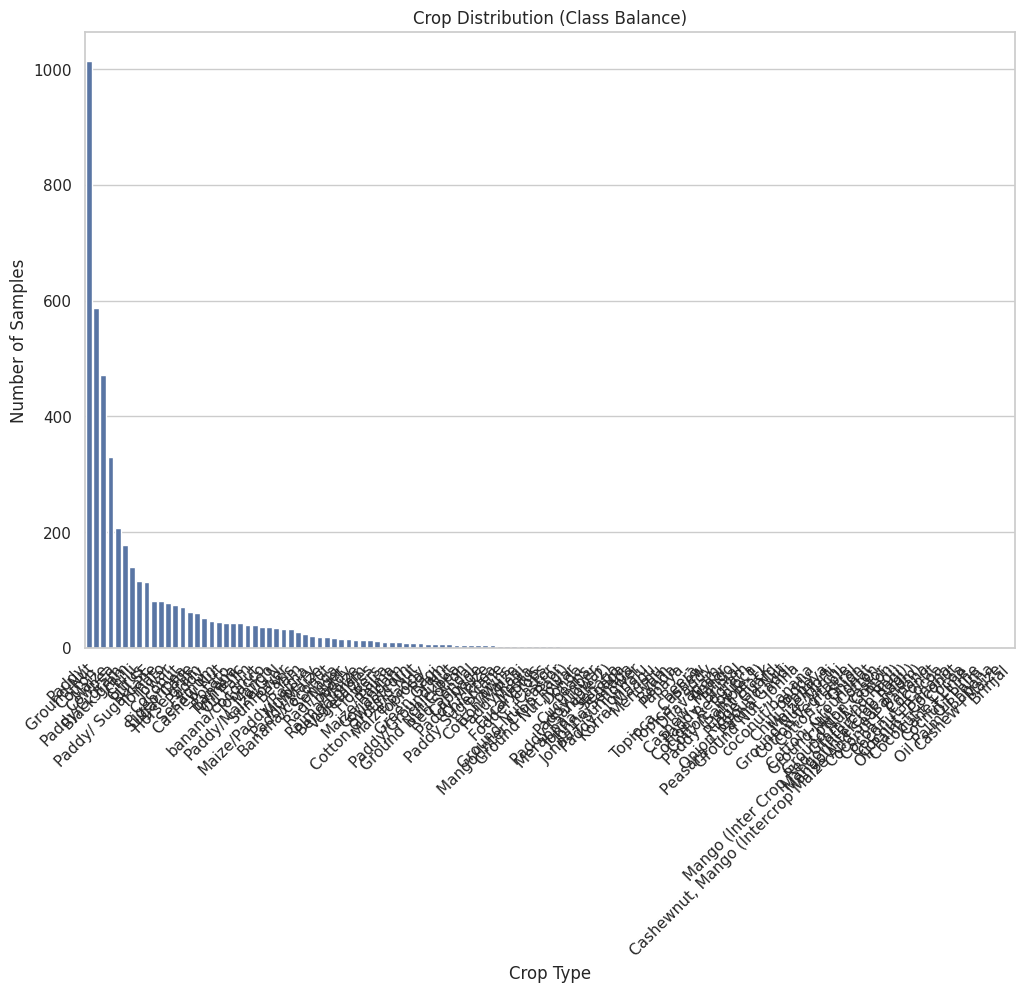


Crop sample counts:
Crop_before
Paddy              1014
Ground Nut          587
Cotton              471
Maize               329
Cowpea              207
                   ... 
Cocnut+Lime           1
Oil Palm              1
Oil Palm+Banana       1
Cashew+Maize          1
Brinjal               1
Name: count, Length: 129, dtype: int64


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set plotting style
sns.set(style="whitegrid")

# ✔ Distribution of Nutrients
print("\n--- EDA: Distribution of Nutrients ---")
# Update nutrient_cols to match the columns in df_processed (using hyphens)
nutrient_cols = ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn']

plt.figure(figsize=(15, 12))
for i, col in enumerate(nutrient_cols):
    plt.subplot(4, 3, i + 1) # Adjust subplot layout
    sns.histplot(df_processed[col], kde=True, bins=20) # Use df_processed instead of data
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()
# This will show if any nutrient values are skewed or follow a normal distribution.

# ✔ Class Balance Analysis
# The target variable for our recommendation system is the crop.
print("\n--- EDA: Class Balance Analysis ---")
plt.figure(figsize=(12, 8))
# Use df_processed and the standardized Soil_Type_Standard and Crop before columns
crop_counts = df_processed['Crop_before'].value_counts() # Assuming Crop_before is the relevant crop column
sns.barplot(x=crop_counts.index, y=crop_counts.values)
plt.title('Crop Distribution (Class Balance)')
plt.xlabel('Crop Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

print("\nCrop sample counts:")
print(crop_counts)
# This is crucial. If some crops have very few samples, the model may struggle to learn their patterns.

In [49]:
# --- Feature Engineering ---

# ✔ Interaction Terms
# Create ratios between key nutrients, which can be more informative than absolute values.
# Use df_processed and correct column names ('Avail-P', 'Exch-K')
# Avoid division by zero
df_processed['N_P_ratio'] = df_processed['OC'] / (df_processed['Avail-P'] + 1e-6)
df_processed['P_K_ratio'] = df_processed['Avail-P'] / (df_processed['Exch-K'] + 1e-6)
df_processed['N_K_ratio'] = df_processed['OC'] / (df_processed['Exch-K'] + 1e-6)
print("\nCreated new features (nutrient ratios): N_P_ratio, P_K_ratio, N_K_ratio")

# ✔ Crop Clustering
# This is an unsupervised learning approach to see if crops naturally group by soil/climate conditions.
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer # Import SimpleImputer

print("\n--- Feature Engineering: Crop Clustering ---")
# Select features for clustering - using numerical columns from df_processed
# Define numerical_features based on df_processed
numerical_features = df_processed.select_dtypes(include=np.number).columns.tolist()
cluster_features = df_processed[numerical_features]

# Handle missing values using imputation
# Impute with the mean of each column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
cluster_features_imputed = imputer.fit_transform(cluster_features)


# Scale the data
scaler_cluster = StandardScaler()
# Scale the imputed features
cluster_scaled = scaler_cluster.fit_transform(cluster_features_imputed)

# Apply K-Means clustering
# Let's assume we want to find 4-5 major groups of crop conditions
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
# Add cluster labels to df_processed
df_processed['crop_cluster'] = kmeans.fit_predict(cluster_scaled)

# Analyze the clusters
print("Crop distribution per cluster:")
# Ensure 'Crop_before' column is used if that's the intended crop column
print(pd.crosstab(df_processed['crop_cluster'], df_processed['Crop_before']))


# ✔ Dimensionality Reduction (PCA)
# PCA can be used to reduce the number of features, especially if multicollinearity is high.
from sklearn.decomposition import PCA

print("\n--- Feature Engineering: PCA ---")
# Using the imputed and scaled numerical features from before (cluster_scaled)
# If you want to apply PCA after imputation and scaling for clustering:
features_scaled_for_pca = cluster_scaled # Reuse the already imputed and scaled data


# Apply PCA
pca = PCA(n_components=0.95) # Retain 95% of the variance
principal_components = pca.fit_transform(features_scaled_for_pca)

# Create a new DataFrame with principal components (optional, can also use the array directly)
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC_{i+1}' for i in range(principal_components.shape[1])])
print(f"Original number of features: {len(numerical_features)}")
print(f"Reduced number of features (PCA): {pca.n_components_}")

# You can then use this pca_df (or principal_components) for modeling instead of the original numerical features.


Created new features (nutrient ratios): N_P_ratio, P_K_ratio, N_K_ratio

--- Feature Engineering: Crop Clustering ---
Crop distribution per cluster:
Crop_before      -  Anaar  Bajra  Banana  Banana/coconut  Beans  Beera  Benda  \
crop_cluster                                                                    
0             0  0      0      7      15               1      0      0      0   
1             1  0      0      0      19              16      1      0      0   
2             0  0      0      1       2               0      0      0      0   
3             0  1      1      1       2               0     10      0      0   
4             0  0      0      1       4               0     17      1      1   

Crop_before   Bengalgram  ...  Turmeric  Vegetables  Yam  banana/coconut  \
crop_cluster              ...                                              
0                     13  ...        33           9   21               3   
1                      0  ...         1           0   

In [51]:
import pandas as pd
import numpy as np

# Assuming df_normalized is available from a previous cell (e.g., after normalization/scaling)

# Separate columns by data type for targeted analysis
# Redefine continuous to include all numerical columns for correlation analysis
discrete = [col for col in df_normalized.columns if df_normalized[col].dtype != 'object' and df_normalized[col].nunique() < 10]
continuous = df_normalized.select_dtypes(include=np.number).columns.tolist()
categorical = [col for col in df_normalized.columns if df_normalized[col].dtype == 'object']

print(f"Discrete variables: {discrete}")
print(f"Continuous variables: {continuous}")
print(f"Categorical variables: {categorical}")

Discrete variables: ['State Code', 'JANUARY NORMAL RAINFALL (Millimeters)', 'DECEMBER NORMAL RAINFALL (Millimeters)']
Continuous variables: ['Sl no', 'Latitude', 'Longitude', 'pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-Ca', 'Avail-Mg', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn', 'Dist Code', 'State Code', 'JANUARY NORMAL RAINFALL (Millimeters)', 'FEBRUARY NORMAL RAINFALL (Millimeters)', 'MARCH NORMAL RAINFALL (Millimeters)', 'APRIL NORMAL RAINFALL (Millimeters)', 'MAY NORMAL RAINFALL (Millimeters)', 'JUNE NORMAL RAINFALL (Millimeters)', 'JULY NORMAL RAINFALL (Millimeters)', 'AUGUST NORMAL RAINFALL (Millimeters)', 'SEPTEMBER NORMAL RAINFALL (Millimeters)', 'OCTOBER NORMAL RAINFALL (Millimeters)', 'NOVEMBER NORMAL RAINFALL (Millimeters)', 'DECEMBER NORMAL RAINFALL (Millimeters)', 'ANNUAL NORMAL RAINFALL (Millimeters)']
Categorical variables: ['Date', 'Farmer No', 'Macro/ Micro nutrient', 'Farmer Name', 'District', 'Mandal', 'Village', 'Survey No.', 'Soil type'

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import io
import re

# Assuming necessary functions like load_and_clean_data are defined in a previous cell (e.g., Upr1ocXZKkPh)
# Also assuming merged_df is available and contains the merged data including rainfall.


# --- Part 1: Data Loading and Preparation Function ---
def load_and_prepare_data():
    """
    Loads merged_df, applies necessary processing (SFI, categories),
    selects features/target based on user request, and prepares data for modeling.
    """
    # Assume merged_df is globally available. Check if it exists.
    if 'merged_df' not in globals():
        print("Error: 'merged_df' not found. Please ensure data loading and merging steps are executed.")
        return None, None, None # Return 3 Nones as expected by the calling code

    df = merged_df.copy() # Work on a copy to avoid modifying the global merged_df

    print("\n--- Data Preparation for Modeling ---")
    print("Initial dataframe shape:", df.shape)
    print("Columns available initially:", df.columns.tolist())
    print("-" * 30)

    # --- Apply necessary processing steps to df ---
    # These steps are copied and adapted from previous working logic

    # Standardize Soil Type
    def standardize_soil(raw: str) -> str:
        if not isinstance(raw, str): return "Other"
        text = raw.lower().replace('soil', '').strip()
        if "black" in text: return "Black"
        if "red" in text or "erra" in text: return "Red"
        if "sand" in text: return "Sandy"
        if "clay" in text: return "Clay"
        if "loam" in text: return "Loam"
        return "Other"

    # Check for original or cleaned soil column name
    soil_col_original = 'Soil type'
    soil_col_cleaned = 'Soil_type'

    if soil_col_original in df.columns:
        df['Soil_Type_Standard'] = df[soil_col_original].apply(standardize_soil)
    elif soil_col_cleaned in df.columns:
         df['Soil_Type_Standard'] = df[soil_col_cleaned].apply(standardize_soil)
    else:
         df['Soil_Type_Standard'] = 'Unknown' # Default if soil column not found
         print(f"Warning: Neither '{soil_col_original}' nor '{soil_col_cleaned}' found for soil standardization. 'Soil_Type_Standard' set to 'Unknown'.")


    # Define nutrient sufficiency levels and weights
    nutrient_sufficiency = {
        'OC':       {'low': 0.5, 'medium': 0.75}, 'Avail-P': {'low': 10, 'medium': 25},
        'Exch-K':   {'low': 120, 'medium': 280}, 'Avail-S': {'low': 10, 'medium': 20},
        'Avail-Zn': {'low': 0.6, 'medium': 1.2}, 'Avail-B': {'low': 0.5, 'medium': 1.0}
    }

    sfi_weights = {
        'pH': 0.10, 'EC': 0.05, 'OC': 0.15, 'Avail-P': 0.10, 'Exch-K': 0.10,
        'Avail-S': 0.05, 'Avail-Ca': 0.05, 'Avail-Mg': 0.05, 'Avail-Zn': 0.05,
        'Avail-B': 0.05, 'Avail-Fe': 0.05, 'Avail-Cu': 0.05, 'Avail-Mn': 0.05
    }

    # Define scoring function for pH (Optimal is Medium rating = score 3)
    def rate_ph_score(ph):
        if pd.isna(ph): return np.nan
        if 6.5 <= ph <= 7.5: return 3
        elif (5.5 <= ph < 6.5) or (7.5 < ph <= 8.5): return 2
        else: return 1

    # Define scoring function for EC (Inverse scoring - Low EC is best = score 3)
    def rate_ec_score(ec):
        if pd.isna(ec): return np.nan
        if ec <= 1.0: return 3
        elif 1.0 < ec <= 3.0: return 2
        else: return 1

    # Function to assign a standard rating based on sufficiency levels
    def get_standard_rating(value, limits):
        if pd.isna(value): return np.nan
        if value <= limits['low']: return 1
        elif value <= limits['medium']:
            return 2
        else: return 3

    # Calculate SFI on the current dataframe
    # Create rating columns for each nutrient included in weights, checking existence
    rating_cols = []
    for nutrient, weight in sfi_weights.items():
        rating_col_name = f'{nutrient}_rating'
        if nutrient in df.columns: # Check if the nutrient column exists
            df[nutrient] = pd.to_numeric(df[nutrient], errors='coerce') # Ensure nutrient column is numeric

            if nutrient == 'pH':
                df[rating_col_name] = df[nutrient].apply(rate_ph_score)
            elif nutrient == 'EC':
                df[rating_col_name] = df[nutrient].apply(rate_ec_score)
            elif nutrient in nutrient_sufficiency:
                 df[rating_col_name] = df[nutrient].apply(lambda x: get_standard_rating(x, nutrient_sufficiency[nutrient]))
            # Add other nutrient ratings if needed based on placeholder_sufficiency or other logic
            elif nutrient in ['Avail-Ca', 'Avail-Mg', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn']:
                 placeholder_sufficiency = {
                     'Avail-Ca': {'low': 800, 'medium': 2000}, 'Avail-Mg': {'low': 180, 'medium': 500},
                     'Avail-Fe': {'low': 4.5, 'medium': 9.0}, 'Avail-Cu': {'low': 0.2, 'medium': 0.4},
                     'Avail-Mn': {'low': 2.0, 'medium': 4.0},
                 }
                 if nutrient in placeholder_sufficiency:
                      df[rating_col_name] = df[nutrient].apply(lambda x: get_standard_rating(x, placeholder_sufficiency[nutrient]))

            # Add the rating column to the list if it was created and exists
            if rating_col_name in df.columns:
                rating_cols.append(rating_col_name)
        else:
             print(f"Warning: Nutrient column '{nutrient}' not found in dataframe for SFI calculation.")


    # Calculate the weighted SFI Score
    df['SFI_Score'] = 0
    # Use only rating columns that were actually created
    valid_rating_cols = [col for col in rating_cols if col in df.columns]

    if valid_rating_cols:
        # Calculate sum of weighted ratings
        for col in valid_rating_cols:
            nutrient_name = col.replace('_rating', '')
            if nutrient_name in sfi_weights:
                 df['SFI_Score'] += df[col].fillna(0) * sfi_weights[nutrient_name]

        # Calculate total weight used per row
        df['Total_Weight_Per_Row'] = 0
        for col in valid_rating_cols:
             nutrient_name = col.replace('_rating', '')
             if nutrient_name in sfi_weights:
                  df['Total_Weight_Per_Row'] += df[col].notna() * sfi_weights[nutrient_name]

        # Normalize SFI Score by the actual sum of weights for available nutrients in that row
        df['SFI_Score'] = df['SFI_Score'] / df['Total_Weight_Per_Row'].replace(0, np.nan)

        # Drop the temporary total weight column
        df.drop(columns=['Total_Weight_Per_Row'], inplace=True, errors='ignore')
    else:
        df['SFI_Score'] = np.nan # Cannot calculate SFI if no valid rating columns


    # Categorize the SFI score (using quantiles for categorization)
    if 'SFI_Score' in df.columns and df['SFI_Score'].dropna().shape[0] >= 3:
        try:
            sfi_bins = [df['SFI_Score'].min() - 0.01, df['SFI_Score'].quantile(0.33), df['SFI_Score'].quantile(0.66), df['SFI_Score'].max() + 0.01]
            unique_bins = sorted(list(set(sfi_bins)))
            if len(unique_bins) >= 2:
                 df['SFI_Category'] = pd.cut(df['SFI_Score'], bins=unique_bins, labels=['Low', 'Medium', 'High'][:len(unique_bins)-1], right=True)
            else:
                 df['SFI_Category'] = 'Unknown'
        except Exception as e:
             print(f"Error during SFI categorization: {e}")
             df['SFI_Category'] = 'Unknown'
    else:
         df['SFI_Category'] = 'Unknown'


    # Add pH Category
    def rate_ph(ph):
        if pd.isna(ph): return 'Unknown'
        if ph < 5.5: return 'Very Acidic'
        if 5.5 <= ph < 6.5: return 'Acidic'
        if 6.5 <= ph <= 7.5: return 'Optimal'
        if 7.5 < ph <= 8.5: return 'Slightly Alkaline'
        return 'Very Alkaline'
    if 'pH' in df.columns:
        df['pH_Category'] = df['pH'].apply(rate_ph)
    else:
        df['pH_Category'] = 'Unknown'
        print("Warning: 'pH' column not found for pH categorization. 'pH_Category' set to 'Unknown'.")

    print("\nFinished applying processing steps (Soil Type Standard, SFI, Categories).")
    print("Columns after processing:", df.columns.tolist())
    print("-" * 30)


    # --- Define the target column ---
    crop_col_name = None
    if 'Crop_before' in df.columns:
        crop_col_name = 'Crop_before'
    elif 'Crop before' in df.columns:
        crop_col_name = 'Crop before'
    else:
         print("Error: Neither 'Crop_before' nor 'Crop before' column found for target variable.")
         return None, None, None


    # --- Define the features based on the user's request ---
    # Include SFI_Score, SFI_Category, pH_Category, Soil_Type_Standard, and Rainfall
    # These columns should now exist after the processing steps above
    feature_cols_to_include_requested = ['SFI_Score', 'SFI_Category', 'pH_Category', 'Soil_Type_Standard']
    rainfall_col = 'ANNUAL_NORMAL_RAINFALL_Millimeters'
    if rainfall_col in df.columns:
        feature_cols_to_include_requested.append(rainfall_col)
    else:
        print(f"Warning: Rainfall column '{rainfall_col}' not found in dataframe. Excluding from features.")

    # Filter to include only the requested feature columns that are actually present in the dataframe
    # This check now happens *after* SFI and category columns are created
    all_feature_cols = [col for col in feature_cols_to_include_requested if col in df.columns]

    # Ensure we have at least one feature column selected
    if not all_feature_cols:
        print(f"Error: No feature columns found in dataframe after checking availability based on user request.")
        print(f"Requested features: {feature_cols_to_include_requested}")
        print(f"Columns available in dataframe after processing: {df.columns.tolist()}")
        return None, None, None


    # --- Data Cleaning for Modeling ---

    # Define columns to drop NaNs from (features + target)
    # Ensure the target column is also included for dropping NaNs
    cols_for_dropna = all_feature_cols.copy() # Start with feature columns
    if crop_col_name in df.columns: # Check if target column exists before adding
        cols_for_dropna.append(crop_col_name)
    else:
         print(f"Critical Error: Target column '{crop_col_name}' not found in dataframe for NaT drop.")
         return None, None, None

    # Ensure all columns in cols_for_dropna actually exist in df before dropping
    cols_for_dropna_present = [col for col in cols_for_dropna if col in df.columns]

    if cols_for_dropna_present:
         initial_rows = len(df)
         df.dropna(subset=cols_for_dropna_present, inplace=True)
         print(f"\nData cleaned for modeling. Started with {initial_rows} rows, working with {len(df)} rows after dropping NaNs in essential features/target.")
    else:
         print("\nNo essential columns found for dropping rows with missing values. Working with original number of rows.")


    # Select features (X) and target (y) from the cleaned dataframe
    # Use the list of available feature columns + the target column name
    if crop_col_name not in df.columns:
         print(f"Critical Error: Target column '{crop_col_name}' not found in dataframe after cleaning.")
         return None, None, None

    X = df[all_feature_cols] # X now contains only the selected feature columns
    y = df[crop_col_name]

    # --- Handle classes with only one member for stratification ---
    # Count the occurrences of each crop in the *cleaned* y
    crop_counts = y.value_counts()
    # Identify crops with only one sample
    single_sample_crops = crop_counts[crop_counts == 1].index
    if not single_sample_crops.empty:
        print(f"\nRemoving {len(single_sample_crops)} crop types with only one sample for stratification:")
        print(list(single_sample_crops))
        # Filter the dataframe to exclude rows with these crop types
        # Use the indices of the current df to filter
        df = df[~df[crop_col_name].isin(single_sample_crops)].copy() # Use .copy() to avoid SettingWithCopyWarning

        # Re-select features and target from the filtered dataframe
        # Use the column names already identified in all_feature_cols
        if crop_col_name not in df.columns:
             print(f"Critical Error: Target column '{crop_col_name}' not found in dataframe after removing single-sample classes.")
             return None, None, None

        # Ensure all selected feature columns are still in the filtered df
        all_feature_cols_after_filter = [col for col in all_feature_cols if col in df.columns]

        X = df[all_feature_cols_after_filter] # X now contains only the selected and available feature columns
        y = df[crop_col_name]

        print(f"Working with {len(df)} rows after removing single-sample crops.")
    # --- End of handling single-sample classes ---

    # Final check if we still have enough data for modeling
    # Need at least 2 samples and at least 2 classes to split with stratification
    if X.empty or y.empty or len(X) < 2 or len(y.unique()) < 2:
         print(f"\nError: Not enough data remaining for modeling after cleaning and removing single-sample classes.")
         print(f"Remaining rows: {len(X)}")
         print(f"Remaining unique classes: {len(y.unique()) if not y.empty else 0}")
         # Print the remaining classes and their counts for diagnosis
         if not y.empty:
              print("\nRemaining crop counts:")
              print(y.value_counts())

         return None, None, None


    # Handle categorical features in X (e.g., one-hot encoding)
    # Identify categorical columns within the selected features X
    categorical_features_for_encoding = [col for col in X.columns if X[col].dtype == 'object']

    if categorical_features_for_encoding:
        print(f"\nOne-hot encoding categorical features: {categorical_features_for_encoding}")
        X = pd.get_dummies(X, columns=categorical_features_for_encoding, dummy_na=False) # Use dummy_na=False unless NaN categories are meaningful


    # Encode the target variable 'Crop_before'
    # Ensure there are still classes to encode after filtering
    if y.empty:
        print("\nError: Target variable is empty after cleaning and filtering.")
        return None, None, None

    crop_encoder = LabelEncoder()
    y_encoded = crop_encoder.fit_transform(y)

    print("\nFeatures (X) and Target (y) prepared for modeling.")
    print("Features shape:", X.shape)
    print("Target shape:", y_encoded.shape)
    print("\nFeatures (X) head:")
    display(X.head())
    print("\nTarget (y) head:")
    display(y.head())


    # Return X, y_encoded, and the encoder
    return X, y_encoded, crop_encoder

# --- 3. MAIN EXECUTION SCRIPT ---

# Load and prepare the data for modeling
# Call the function without filenames as it uses merged_df directly
X, y_encoded, crop_encoder = load_and_prepare_data()

if X is not None and y_encoded is not None and crop_encoder is not None:

    # --- 3.1. Define Features (X) and Target (y) & Split Data ---
    # X and y are already prepared by load_and_prepare_data
    y = y_encoded # Use the encoded target

    # Check if there are enough samples and classes for stratification after preparation
    if len(X) < 2 or len(np.unique(y)) < 2:
         print("\nError: Not enough samples or classes remaining after data preparation for stratified split.")
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=0.2,
            random_state=42,
            stratify=y  # Essential for imbalanced multi-class datasets
        )
        print(f"\nData split into {len(X_train)} training and {len(X_test)} testing samples.")

        # --- 3.2. Train the Random Forest Model ---
        print("\n--- Training Random Forest Model ---")
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        print("Model training complete.")

        # --- 3.3. Make Predictions ---
        y_pred = rf_model.predict(X_test)

        # --- 4. PERFORMANCE EVALUATION ---
        print("\n--- Model Performance Evaluation ---")

        # 4.1. Accuracy Score
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Overall Model Accuracy: {accuracy:.4f} ({accuracy:.2%})")

        # 4.2. Classification Report
        print("\nClassification Report:")
        print("This report shows the precision, recall, and F1-score for each crop.")
        print(" - Precision: Of all predictions for a crop, how many were correct?")
        print(" - Recall: Of all actual instances of a crop, how many did the model identify?")
        print(" - F1-Score: A balanced measure of precision and recall.\n")

        # Use the encoder to get actual crop names
        target_names = crop_encoder.classes_
        print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0)) # Added zero_division=0


        # 4.3. Confusion Matrix
        print("\n--- Visualizing the Confusion Matrix ---")
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(12, 10))
        # Limit the number of tick labels if there are too many classes for better readability
        n_classes = len(target_names)
        if n_classes > 30: # Example threshold
            tick_interval = n_classes // 30 # Adjust interval based on number of classes
            sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=target_names[::tick_interval], yticklabels=target_names[::tick_interval])
            plt.xticks(np.arange(len(target_names))[::tick_interval] + 0.5, target_names[::tick_interval], rotation=90)
            plt.yticks(np.arange(len(target_names))[::tick_interval] + 0.5, target_names[::tick_interval], rotation=0)
        else:
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
            plt.xticks(rotation=90)
            plt.yticks(rotation=0)

        plt.title('Confusion Matrix', fontsize=16)
        plt.xlabel('Predicted Crop', fontsize=12)
        plt.ylabel('Actual Crop', fontsize=12)
        plt.tight_layout()
        plt.show()
        print("The confusion matrix helps visualize model performance. The diagonal values are correct predictions. Off-diagonal values show where the model is confusing one crop for another.")

        # --- 5. FEATURE IMPORTANCE ANALYSIS ---
        print("\n--- Analyzing Feature Importance ---")
        # Ensure feature names in X_train match feature importances
        feature_importances = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': rf_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        # Plot the top 15 most important features
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15), palette='viridis')
        plt.title('Top 15 Most Important Features for Crop Recommendation', fontsize=16)
        plt.xlabel('Importance Score', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        plt.show()
        print("This chart shows which features the Random Forest model considered most important when making predictions. Higher scores indicate greater influence.")

        print("\n--- Evaluation Script Finished ---")
else:
    print("\nData loading and preparation failed. Modeling skipped.")


--- Data Preparation for Modeling ---
Initial dataframe shape: (4816, 49)
Columns available initially: ['Sl no', 'Date', 'Farmer No', 'Macro/ Micro nutrient', 'Farmer Name', 'District', 'Mandal', 'Village', 'Latitude', 'Longitude', 'Survey No.', 'Soil type', 'Fathers Name', 'Extent\n(AC)', 'Crop before', 'pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-Ca', 'Avail-Mg', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn', 'Time', 'Season', 'Recommended Sowing Time', 'Dist Code', 'Year', 'State Code', 'State Name', 'Dist Name', 'JANUARY NORMAL RAINFALL (Millimeters)', 'FEBRUARY NORMAL RAINFALL (Millimeters)', 'MARCH NORMAL RAINFALL (Millimeters)', 'APRIL NORMAL RAINFALL (Millimeters)', 'MAY NORMAL RAINFALL (Millimeters)', 'JUNE NORMAL RAINFALL (Millimeters)', 'JULY NORMAL RAINFALL (Millimeters)', 'AUGUST NORMAL RAINFALL (Millimeters)', 'SEPTEMBER NORMAL RAINFALL (Millimeters)', 'OCTOBER NORMAL RAINFALL (Millimeters)', 'NOVEMBER NORMAL RAINFALL (Millimeters)', 'DECEMBER NOR

,SFI_Score,SFI_Category,pH_Category_Acidic,pH_Category_Optimal,pH_Category_Slightly Alkaline,pH_Category_Very Acidic,pH_Category_Very Alkaline,Soil_Type_Standard_Black,Soil_Type_Standard_Clay,Soil_Type_Standard_Loam,Soil_Type_Standard_Other,Soil_Type_Standard_Red,Soil_Type_Standard_Sandy
0,1.500000,Low,True,False,False,False,False,False,False,False,True,False,False
1,1.722222,Low,False,False,True,False,False,False,False,False,False,True,False
2,1.611111,Low,False,True,False,False,False,False,False,False,True,False,False
3,1.555556,Low,False,False,True,False,False,False,False,False,False,False,True
4,1.555556,Low,True,False,False,False,False,False,False,False,True,False,False



Target (y) head:


,Crop before
0,Ground Nut
1,Ground Nut
2,Ground Nut
3,Horse gram
4,Horse gram



Data split into 3632 training and 908 testing samples.

--- Training Random Forest Model ---


ValueError: Cannot cast object dtype to float32